In this notebook I want to play with Jupyter and show the steps of how to create a MEVN application from a notebook. Normally I would do this in the normal Linux terminal and a text editor, but since we can combine code, explanation and shell commands, I want to create a story in this notebook which hopefully will be of any help of people experimenting with full-stack development. I will create the application, use some simple Linux tricks and use Selenium to test the application.

Please note development like this is far from optimal, but I think it is very cool what you can achieve without leaving your notebook, knowing a bit of Docker, Linux and Python.

The original notebook can be found [here](https://github.com/jitsejan/notebooks/blob/master/notebooks/MEVN.ipynb).


## Objective
Setup an application with the following elements

* [MongoDB](https://www.mongodb.com/)
* [ExpressJS](https://expressjs.com/)
* [VueJS](https://vuejs.org/)
* [NodeJS](https://nodejs.org/en/)

using

* [Jupyter](http://jupyter.org/) notebook
* [Docker](https://www.docker.com/)
* [Scrapy](https://scrapy.org/)
* [PyMongo](https://api.mongodb.com/python/current/)
* [Selenium](http://www.seleniumhq.org/)

<img class="logo" src="http://files.jitsejan.com/logos/jupyter.PNG" />

### Notebook settings

In [1]:
%%html
<style>
img.logo{
    height: 100px;
}

img.screenshot{
    max-width:500px; 
    -webkit-filter: drop-shadow(5px 5px 5px #222);
    filter: drop-shadow(2px 5px 5px #222);
    margin: 50px auto;
}
</style>

Clean up the images from earlier runs.

In [2]:
rm *.png

rm: cannot remove '*.png': No such file or directory


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
!jupyter --version

4.4.0


In [5]:
!jupyter notebook --version

5.2.2


<img class="logo" src="http://files.jitsejan.com/logos/python.PNG"/>
### Python version

In [6]:
import platform
platform.python_version()

'3.5.2'

<img class="logo" src="http://files.jitsejan.com/logos/docker.PNG"/>

## Docker setup
### Docker version

In [7]:
!docker version

Client:
 Version:      17.09.0-ce
 API version:  1.32
 Go version:   go1.8.3
 Git commit:   afdb6d4
 Built:        Tue Sep 26 22:42:18 2017
 OS/Arch:      linux/amd64

Server:
 Version:      17.09.0-ce
 API version:  1.32 (minimum version 1.12)
 Go version:   go1.8.3
 Git commit:   afdb6d4
 Built:        Tue Sep 26 22:40:56 2017
 OS/Arch:      linux/amd64
 Experimental: false


In [8]:
!docker ps

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS              PORTS                      NAMES
3661951201a7        selenium/standalone-chrome:latest   "/opt/bin/entry_po..."   About an hour ago   Up About an hour    0.0.0.0:4444->4444/tcp     selenium
a1358fd1eb57        mongo:latest                        "docker-entrypoint..."   2 hours ago         Up 2 hours          0.0.0.0:27017->27017/tcp   mongo


### Docker client
#### Setup the client

```bash
pip3 install docker
```

In [9]:
import docker
docker_client = docker.from_env()

#### Available containers

In [10]:
for cntr in docker_client.containers.list():
    print("name={} (id={})".format(cntr.name, cntr.id))

name=selenium (id=3661951201a72dbb9cf29c6246d1650d9d67ec3b27254ad6f748a27aed6a6ea4)
name=mongo (id=a1358fd1eb57cdcde386873a8134057da60ea9793c809ec6e9ba74a7867886fd)


<img class="logo" src="http://files.jitsejan.com/logos/mongodb.PNG"/>

## MongoDB

Check if the Mongo Docker container is running, otherwise, start the container.

In [11]:
mongo_running = False
for cntr in docker_client.containers.list():
    if 'mongo' in cntr.attrs['Config']['Image']:
        mongo_running = True
        container = cntr
if mongo_running is False:
    container = docker_client.containers.run("mongo:latest", name='mongo', ports={'27017': '27017'}, detach=True)

In [12]:
container

<Container: a1358fd1eb>

Verification that the Mongo container is running:

In [13]:
!docker ps | grep mongo

a1358fd1eb57        mongo:latest                        "docker-entrypoint..."   2 hours ago         Up 2 hours          0.0.0.0:27017->27017/tcp   mongo


See [Documentation](https://api.mongodb.com/python/current/installation.html) to install PyMongo.

```shell
$ pip install pymongo
```

```bash
pip3 install pymongo
```

In [14]:
from pymongo import MongoClient
mongo_client = MongoClient('localhost', 27017)

<img class="logo" src="http://files.jitsejan.com/logos/scrapy.PNG"/>

## Data gathering

Create the Scrapy pipeline to write the scraping results to MongoDB.

In [15]:
import pymongo

class MongoPipeline(object):

    collection_name = 'games'

    def __init__(self, mongo_uri, mongo_db):
        self.mongo_uri = mongo_uri
        self.mongo_db = mongo_db

    @classmethod
    def from_crawler(cls, crawler):
        return cls(
            mongo_uri=crawler.settings.get('MONGO_URI'),
            mongo_db=crawler.settings.get('MONGO_DATABASE', 'items')
        )

    def open_spider(self, spider):
        self.client = pymongo.MongoClient(self.mongo_uri)
        self.db = self.client[self.mongo_db]

    def close_spider(self, spider):
        self.client.close()

    def process_item(self, item, spider):
        self.db[self.collection_name].insert_one(dict(item))
        return item

Retrieving data from https://www.nintendo.co.jp/ir/en/finance/software/index.html with the following markup:

```html
<ul class="sales_layout">
    <li class="sales_layout_list">
        <div class="ta_l">
            <p class="sales_title">The Legend of Zelda:<br> Breath of the Wild</p>
            <p class="sales_value"><span>4.70</span> million pcs.</p>
        </div>
        <div class="ta_r">
            <p>
                <img src="./img/data_switch_001.png" alt="" width="110" height="" class="sales_product1">
            </p>
        </div>
    </li>
</ul>
```

Using Scrapy we can gather the data in a convenient way.

```bash
pip3 install scrapy
```

In [16]:
import logging
import scrapy
from scrapy.crawler import CrawlerProcess
import re

class ConsoleSpider(scrapy.Spider):
    name = "games"
    start_urls = [
        "https://www.nintendo.co.jp/ir/en/finance/software/index.html",
        "https://www.nintendo.co.jp/ir/en/finance/software/wiiu.html",
        "https://www.nintendo.co.jp/ir/en/finance/software/3ds.html",
        "https://www.nintendo.co.jp/ir/en/finance/software/wii.html",
        "https://www.nintendo.co.jp/ir/en/finance/software/ds.html"
    ]
    custom_settings = {
        'LOG_LEVEL': logging.CRITICAL,
        'DOWNLOAD_DELAY': .25,
        'RANDOMIZE_DOWNLOAD_DELAY': True,
        'ITEM_PIPELINES': {
            '__main__.MongoPipeline': 300,
        },
        'MONGO_URI': 'mongodb://localhost:27017',
        'MONGO_DATABASE': 'nintendo'
    }

    def parse(self, response):
         for cons in response.css('li.sales_layout_list'):
            yield {
                'console': response.css('div.tab div.tabInner span::text').extract_first(),
                'name': cons.css('p.sales_title::text').extract_first().strip(),
                'image': 'https://www.nintendo.co.jp/ir/en/finance/software' + cons.css('p img::attr(src)').extract_first()[1:],
                'sales': cons.css('p.sales_value span::text').extract()[0].strip()
            }

In [17]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(ConsoleSpider)
process.start()

2018-01-15 19:01:14 [scrapy.utils.log] INFO: Scrapy 1.5.0 started (bot: scrapybot)
2018-01-15 19:01:14 [scrapy.utils.log] INFO: Versions: lxml 4.1.1.0, libxml2 2.9.7, cssselect 1.0.3, parsel 1.3.1, w3lib 1.18.0, Twisted 17.9.0, Python 3.5.2 (default, Nov 23 2017, 16:37:01) - [GCC 5.4.0 20160609], pyOpenSSL 17.5.0 (OpenSSL 1.1.0g  2 Nov 2017), cryptography 2.1.4, Platform Linux-4.4.0-x86_64-with-Ubuntu-16.04-xenial
2018-01-15 19:01:14 [scrapy.crawler] INFO: Overridden settings: {'LOG_LEVEL': 50, 'DOWNLOAD_DELAY': 0.25, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


#### Verify the Nintendo database is created

In [18]:
if 'nintendo' in mongo_client.database_names():
    print('Database found!')

Database found!


#### Verify the games collection is created inside the Nintendo database

In [19]:
db = mongo_client['nintendo']
if 'games' in db.collection_names():
    print('Collection found!')

Collection found!


#### Retrieve the games from the collection

In [20]:
games = list(db['games'].find({}))

In [21]:
print("Found {} games".format(len(games)))

Found 270 games


## Retrieve the images
#### Delete the old images

In [22]:
!rm -rf images/*

In [23]:
import re
updated_games = []
for gameindex, game in enumerate(games):
    image = game['image']
    image_short = image.split('/')[-1]
    !wget --no-check-certificate $image -P images/ 
    game['image'] = 'images/' + image_short
    game.pop('_id', None)
    updated_games.append(game)

--2018-01-15 19:01:16--  http://images/data_switch_001.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_001.png [following]
--2018-01-15 19:01:16--  https://images/data_switch_001.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780a')

--2018-01-15 19:01:16--  http://images/data_switch_002.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_002.png [following]
--2018-01-15 19:01:16--  https://images/data_switch_002.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780b')

--2018-01-15 19:01:16--  http://images/data_switch_005.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_005.png [following]
--2018-01-15 19:01:16--  https://images/data_switch_005.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780c')

--2018-01-15 19:01:16--  http://images/data_switch_003.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_003.png [following]
--2018-01-15 19:01:16--  https://images/data_switch_003.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780d')

--2018-01-15 19:01:16--  http://images/data_switch_004.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_004.png [following]
--2018-01-15 19:01:16--  https://images/data_switch_004.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780e')

--2018-01-15 19:01:16--  http://images/data_wiiu_mariokart8.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mariokart8.png [following]
--2018-01-15 19:01:16--  https://images/data_wiiu_mariokart8.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:16 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6780f')

--2018-01-15 19:01:17--  http://images/data_wiiu_newmariou.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newmariou.png [following]
--2018-01-15 19:01:17--  https://images/data_wiiu_newmariou.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:17 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67810')

--2018-01-15 19:01:17--  http://images/data_wiiu_mario3dworld.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mario3dworld.png [following]
--2018-01-15 19:01:17--  https://images/data_wiiu_mario3dworld.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:17 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67811')

--2018-01-15 19:01:17--  http://images/data_wiiu_smashbros.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_smashbros.png [following]
--2018-01-15 19:01:17--  https://images/data_wiiu_smashbros.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:17 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67812')

--2018-01-15 19:01:17--  http://images/data_wiiu_nintendoland.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_nintendoland.png [following]
--2018-01-15 19:01:17--  https://images/data_wiiu_nintendoland.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:17 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67813')

--2018-01-15 19:01:18--  http://images/data_wiiu_splatoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_splatoon.jpg [following]
--2018-01-15 19:01:18--  https://images/data_wiiu_splatoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:18 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67814')

--2018-01-15 19:01:18--  http://images/data_wiiu_supermariomaker.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_supermariomaker.png [following]
--2018-01-15 19:01:18--  https://images/data_wiiu_supermariomaker.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:18 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67815')

--2018-01-15 19:01:18--  http://images/data_wiiu_newsuperluigiu.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newsuperluigiu.png [following]
--2018-01-15 19:01:18--  https://images/data_wiiu_newsuperluigiu.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:18 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67816')

--2018-01-15 19:01:18--  http://images/data_wiiu_zeldahd.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_zeldahd.png [following]
--2018-01-15 19:01:18--  https://images/data_wiiu_zeldahd.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:18 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67817')

--2018-01-15 19:01:18--  http://images/data_wiiu_marioparty10.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_marioparty10.jpg [following]
--2018-01-15 19:01:18--  https://images/data_wiiu_marioparty10.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:18 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67818')

--2018-01-15 19:01:18--  http://images/data_3ds_pokemonxy.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonxy.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_pokemonxy.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67819')

--2018-01-15 19:01:19--  http://images/data_3ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_002.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781a')

--2018-01-15 19:01:19--  http://images/data_3ds_pokemonsunmoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonsunmoon.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_pokemonsunmoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781b')

--2018-01-15 19:01:19--  http://images/data_3ds_pokemonoras.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonoras.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_pokemonoras.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781c')

--2018-01-15 19:01:19--  http://images/data_3ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_003.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781d')

--2018-01-15 19:01:19--  http://images/data_3ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_001.jpg [following]
--2018-01-15 19:01:19--  https://images/data_3ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:19 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781e')

--2018-01-15 19:01:20--  http://images/data_3ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_004.jpg [following]
--2018-01-15 19:01:20--  https://images/data_3ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:20 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6781f')

--2018-01-15 19:01:20--  http://images/data_3ds_smashbros.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_smashbros.jpg [following]
--2018-01-15 19:01:20--  https://images/data_3ds_smashbros.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:20 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67820')

--2018-01-15 19:01:20--  http://images/data_3ds_tomodachicollection.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_tomodachicollection.jpg [following]
--2018-01-15 19:01:20--  https://images/data_3ds_tomodachicollection.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:20 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67821')

--2018-01-15 19:01:20--  http://images/data_3ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_009.jpg [following]
--2018-01-15 19:01:20--  https://images/data_3ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:20 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67822')

--2018-01-15 19:01:21--  http://images/data_wii_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_001.jpg [following]
--2018-01-15 19:01:21--  https://images/data_wii_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:21 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67823')

--2018-01-15 19:01:21--  http://images/data_wii_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_002.jpg [following]
--2018-01-15 19:01:21--  https://images/data_wii_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:21 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67824')

--2018-01-15 19:01:22--  http://images/data_wii_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_003.jpg [following]
--2018-01-15 19:01:22--  https://images/data_wii_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:22 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67825')

--2018-01-15 19:01:22--  http://images/data_wii_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_005.jpg [following]
--2018-01-15 19:01:22--  https://images/data_wii_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:22 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67826')

--2018-01-15 19:01:22--  http://images/data_wii_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_004.jpg [following]
--2018-01-15 19:01:22--  https://images/data_wii_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:22 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67827')

--2018-01-15 19:01:22--  http://images/data_wii_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_006.jpg [following]
--2018-01-15 19:01:22--  https://images/data_wii_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:22 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67828')

--2018-01-15 19:01:23--  http://images/data_wii_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_007.jpg [following]
--2018-01-15 19:01:23--  https://images/data_wii_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:23 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67829')

--2018-01-15 19:01:23--  http://images/data_wii_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_009.jpg [following]
--2018-01-15 19:01:23--  https://images/data_wii_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:23 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782a')

--2018-01-15 19:01:23--  http://images/data_wii_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_008.jpg [following]
--2018-01-15 19:01:23--  https://images/data_wii_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:23 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782b')

--2018-01-15 19:01:23--  http://images/data_wii_wiiparty.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_wiiparty.jpg [following]
--2018-01-15 19:01:23--  https://images/data_wii_wiiparty.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:23 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782c')

--2018-01-15 19:01:24--  http://images/data_ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_001.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782d')

--2018-01-15 19:01:24--  http://images/data_ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_003.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782e')

--2018-01-15 19:01:24--  http://images/data_ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_002.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6782f')

--2018-01-15 19:01:24--  http://images/data_ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_004.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67830')

--2018-01-15 19:01:24--  http://images/data_ds_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_006.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67831')

--2018-01-15 19:01:24--  http://images/data_ds_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_007.jpg [following]
--2018-01-15 19:01:24--  https://images/data_ds_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:24 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67832')

--2018-01-15 19:01:25--  http://images/data_ds_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_005.jpg [following]
--2018-01-15 19:01:25--  https://images/data_ds_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:25 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67833')

--2018-01-15 19:01:25--  http://images/data_ds_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_008.jpg [following]
--2018-01-15 19:01:25--  https://images/data_ds_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:25 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67834')

--2018-01-15 19:01:25--  http://images/data_ds_010.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_010.jpg [following]
--2018-01-15 19:01:25--  https://images/data_ds_010.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:25 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67835')

--2018-01-15 19:01:25--  http://images/data_ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_009.jpg [following]
--2018-01-15 19:01:25--  https://images/data_ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:25 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67836')

--2018-01-15 19:01:25--  http://images/data_switch_001.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_001.png [following]
--2018-01-15 19:01:25--  https://images/data_switch_001.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:25 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67837')

--2018-01-15 19:01:26--  http://images/data_switch_002.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_002.png [following]
--2018-01-15 19:01:26--  https://images/data_switch_002.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:26 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67838')

--2018-01-15 19:01:26--  http://images/data_switch_005.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_005.png [following]
--2018-01-15 19:01:26--  https://images/data_switch_005.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:26 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67839')

--2018-01-15 19:01:27--  http://images/data_switch_003.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_003.png [following]
--2018-01-15 19:01:27--  https://images/data_switch_003.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:27 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783a')

--2018-01-15 19:01:27--  http://images/data_switch_004.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_004.png [following]
--2018-01-15 19:01:27--  https://images/data_switch_004.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:27 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783b')

--2018-01-15 19:01:27--  http://images/data_wiiu_mariokart8.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mariokart8.png [following]
--2018-01-15 19:01:27--  https://images/data_wiiu_mariokart8.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:27 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783c')

--2018-01-15 19:01:27--  http://images/data_wiiu_newmariou.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newmariou.png [following]
--2018-01-15 19:01:27--  https://images/data_wiiu_newmariou.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:27 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783d')

--2018-01-15 19:01:27--  http://images/data_wiiu_mario3dworld.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mario3dworld.png [following]
--2018-01-15 19:01:27--  https://images/data_wiiu_mario3dworld.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:27 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783e')

--2018-01-15 19:01:28--  http://images/data_wiiu_smashbros.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_smashbros.png [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_smashbros.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6783f')

--2018-01-15 19:01:28--  http://images/data_wiiu_nintendoland.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_nintendoland.png [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_nintendoland.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67840')

--2018-01-15 19:01:28--  http://images/data_wiiu_splatoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_splatoon.jpg [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_splatoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67841')

--2018-01-15 19:01:28--  http://images/data_wiiu_supermariomaker.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_supermariomaker.png [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_supermariomaker.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67842')

--2018-01-15 19:01:28--  http://images/data_wiiu_newsuperluigiu.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newsuperluigiu.png [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_newsuperluigiu.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67843')

--2018-01-15 19:01:28--  http://images/data_wiiu_zeldahd.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_zeldahd.png [following]
--2018-01-15 19:01:28--  https://images/data_wiiu_zeldahd.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:28 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67844')

--2018-01-15 19:01:29--  http://images/data_wiiu_marioparty10.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_marioparty10.jpg [following]
--2018-01-15 19:01:29--  https://images/data_wiiu_marioparty10.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:29 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67845')

--2018-01-15 19:01:29--  http://images/data_3ds_pokemonxy.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonxy.jpg [following]
--2018-01-15 19:01:29--  https://images/data_3ds_pokemonxy.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:29 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67846')

--2018-01-15 19:01:29--  http://images/data_3ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_002.jpg [following]
--2018-01-15 19:01:29--  https://images/data_3ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:29 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67847')

--2018-01-15 19:01:29--  http://images/data_3ds_pokemonsunmoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonsunmoon.jpg [following]
--2018-01-15 19:01:29--  https://images/data_3ds_pokemonsunmoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:29 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67848')

--2018-01-15 19:01:30--  http://images/data_3ds_pokemonoras.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonoras.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_pokemonoras.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67849')

--2018-01-15 19:01:30--  http://images/data_3ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_003.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784a')

--2018-01-15 19:01:30--  http://images/data_3ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_001.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784b')

--2018-01-15 19:01:30--  http://images/data_3ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_004.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784c')

--2018-01-15 19:01:30--  http://images/data_3ds_smashbros.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_smashbros.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_smashbros.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784d')

--2018-01-15 19:01:30--  http://images/data_3ds_tomodachicollection.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_tomodachicollection.jpg [following]
--2018-01-15 19:01:30--  https://images/data_3ds_tomodachicollection.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:30 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784e')

--2018-01-15 19:01:31--  http://images/data_3ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_009.jpg [following]
--2018-01-15 19:01:31--  https://images/data_3ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:31 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6784f')

--2018-01-15 19:01:31--  http://images/data_wii_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_001.jpg [following]
--2018-01-15 19:01:31--  https://images/data_wii_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:31 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67850')

--2018-01-15 19:01:31--  http://images/data_wii_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_002.jpg [following]
--2018-01-15 19:01:31--  https://images/data_wii_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:31 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67851')

--2018-01-15 19:01:32--  http://images/data_wii_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_003.jpg [following]
--2018-01-15 19:01:32--  https://images/data_wii_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:32 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67852')

--2018-01-15 19:01:32--  http://images/data_wii_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_005.jpg [following]
--2018-01-15 19:01:32--  https://images/data_wii_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:32 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67853')

--2018-01-15 19:01:32--  http://images/data_wii_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_004.jpg [following]
--2018-01-15 19:01:32--  https://images/data_wii_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:32 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67854')

--2018-01-15 19:01:32--  http://images/data_wii_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_006.jpg [following]
--2018-01-15 19:01:32--  https://images/data_wii_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:32 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67855')

--2018-01-15 19:01:32--  http://images/data_wii_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_007.jpg [following]
--2018-01-15 19:01:32--  https://images/data_wii_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:32 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67856')

--2018-01-15 19:01:33--  http://images/data_wii_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_009.jpg [following]
--2018-01-15 19:01:33--  https://images/data_wii_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:33 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67857')

--2018-01-15 19:01:33--  http://images/data_wii_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_008.jpg [following]
--2018-01-15 19:01:33--  https://images/data_wii_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:33 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67858')

--2018-01-15 19:01:33--  http://images/data_wii_wiiparty.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_wiiparty.jpg [following]
--2018-01-15 19:01:33--  https://images/data_wii_wiiparty.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:33 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67859')

--2018-01-15 19:01:33--  http://images/data_ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_001.jpg [following]
--2018-01-15 19:01:33--  https://images/data_ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:33 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785a')

--2018-01-15 19:01:34--  http://images/data_ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_003.jpg [following]
--2018-01-15 19:01:34--  https://images/data_ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:34 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785b')

--2018-01-15 19:01:34--  http://images/data_ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_002.jpg [following]
--2018-01-15 19:01:34--  https://images/data_ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:34 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785c')

--2018-01-15 19:01:34--  http://images/data_ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_004.jpg [following]
--2018-01-15 19:01:34--  https://images/data_ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:34 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785d')

--2018-01-15 19:01:34--  http://images/data_ds_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_006.jpg [following]
--2018-01-15 19:01:34--  https://images/data_ds_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:34 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785e')

--2018-01-15 19:01:35--  http://images/data_ds_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_007.jpg [following]
--2018-01-15 19:01:35--  https://images/data_ds_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:35 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6785f')

--2018-01-15 19:01:35--  http://images/data_ds_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_005.jpg [following]
--2018-01-15 19:01:35--  https://images/data_ds_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:35 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67860')

--2018-01-15 19:01:35--  http://images/data_ds_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_008.jpg [following]
--2018-01-15 19:01:36--  https://images/data_ds_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67861')

--2018-01-15 19:01:36--  http://images/data_ds_010.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_010.jpg [following]
--2018-01-15 19:01:36--  https://images/data_ds_010.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67862')

--2018-01-15 19:01:36--  http://images/data_ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_009.jpg [following]
--2018-01-15 19:01:36--  https://images/data_ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67863')

--2018-01-15 19:01:36--  http://images/data_switch_001.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_001.png [following]
--2018-01-15 19:01:36--  https://images/data_switch_001.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67864')

--2018-01-15 19:01:36--  http://images/data_switch_002.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_002.png [following]
--2018-01-15 19:01:36--  https://images/data_switch_002.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67865')

--2018-01-15 19:01:36--  http://images/data_switch_005.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_005.png [following]
--2018-01-15 19:01:36--  https://images/data_switch_005.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:36 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67866')

--2018-01-15 19:01:37--  http://images/data_switch_003.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_003.png [following]
--2018-01-15 19:01:37--  https://images/data_switch_003.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67867')

--2018-01-15 19:01:37--  http://images/data_switch_004.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_004.png [following]
--2018-01-15 19:01:37--  https://images/data_switch_004.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67868')

--2018-01-15 19:01:37--  http://images/data_wiiu_mariokart8.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mariokart8.png [following]
--2018-01-15 19:01:37--  https://images/data_wiiu_mariokart8.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67869')

--2018-01-15 19:01:37--  http://images/data_wiiu_newmariou.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newmariou.png [following]
--2018-01-15 19:01:37--  https://images/data_wiiu_newmariou.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786a')

--2018-01-15 19:01:37--  http://images/data_wiiu_mario3dworld.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mario3dworld.png [following]
--2018-01-15 19:01:37--  https://images/data_wiiu_mario3dworld.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786b')

--2018-01-15 19:01:37--  http://images/data_wiiu_smashbros.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_smashbros.png [following]
--2018-01-15 19:01:37--  https://images/data_wiiu_smashbros.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:37 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786c')

--2018-01-15 19:01:38--  http://images/data_wiiu_nintendoland.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_nintendoland.png [following]
--2018-01-15 19:01:38--  https://images/data_wiiu_nintendoland.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:38 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786d')

--2018-01-15 19:01:38--  http://images/data_wiiu_splatoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_splatoon.jpg [following]
--2018-01-15 19:01:38--  https://images/data_wiiu_splatoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:38 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786e')

--2018-01-15 19:01:38--  http://images/data_wiiu_supermariomaker.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_supermariomaker.png [following]
--2018-01-15 19:01:38--  https://images/data_wiiu_supermariomaker.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:38 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6786f')

--2018-01-15 19:01:38--  http://images/data_wiiu_newsuperluigiu.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newsuperluigiu.png [following]
--2018-01-15 19:01:38--  https://images/data_wiiu_newsuperluigiu.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:38 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67870')

--2018-01-15 19:01:38--  http://images/data_wiiu_zeldahd.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_zeldahd.png [following]
--2018-01-15 19:01:38--  https://images/data_wiiu_zeldahd.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:38 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67871')

--2018-01-15 19:01:39--  http://images/data_wiiu_marioparty10.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_marioparty10.jpg [following]
--2018-01-15 19:01:39--  https://images/data_wiiu_marioparty10.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:39 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67872')

--2018-01-15 19:01:39--  http://images/data_3ds_pokemonxy.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonxy.jpg [following]
--2018-01-15 19:01:39--  https://images/data_3ds_pokemonxy.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:39 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67873')

--2018-01-15 19:01:40--  http://images/data_3ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_002.jpg [following]
--2018-01-15 19:01:40--  https://images/data_3ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:40 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67874')

--2018-01-15 19:01:40--  http://images/data_3ds_pokemonsunmoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonsunmoon.jpg [following]
--2018-01-15 19:01:40--  https://images/data_3ds_pokemonsunmoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:40 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67875')

--2018-01-15 19:01:40--  http://images/data_3ds_pokemonoras.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonoras.jpg [following]
--2018-01-15 19:01:40--  https://images/data_3ds_pokemonoras.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:40 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67876')

--2018-01-15 19:01:40--  http://images/data_3ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_003.jpg [following]
--2018-01-15 19:01:40--  https://images/data_3ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:40 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67877')

--2018-01-15 19:01:40--  http://images/data_3ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_001.jpg [following]
--2018-01-15 19:01:40--  https://images/data_3ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:40 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67878')

--2018-01-15 19:01:41--  http://images/data_3ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_004.jpg [following]
--2018-01-15 19:01:41--  https://images/data_3ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:41 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67879')

--2018-01-15 19:01:41--  http://images/data_3ds_smashbros.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_smashbros.jpg [following]
--2018-01-15 19:01:41--  https://images/data_3ds_smashbros.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:41 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787a')

--2018-01-15 19:01:41--  http://images/data_3ds_tomodachicollection.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_tomodachicollection.jpg [following]
--2018-01-15 19:01:41--  https://images/data_3ds_tomodachicollection.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:41 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787b')

--2018-01-15 19:01:42--  http://images/data_3ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_009.jpg [following]
--2018-01-15 19:01:42--  https://images/data_3ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787c')

--2018-01-15 19:01:42--  http://images/data_wii_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_001.jpg [following]
--2018-01-15 19:01:42--  https://images/data_wii_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787d')

--2018-01-15 19:01:42--  http://images/data_wii_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_002.jpg [following]
--2018-01-15 19:01:42--  https://images/data_wii_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787e')

--2018-01-15 19:01:42--  http://images/data_wii_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_003.jpg [following]
--2018-01-15 19:01:42--  https://images/data_wii_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6787f')

--2018-01-15 19:01:42--  http://images/data_wii_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_005.jpg [following]
--2018-01-15 19:01:42--  https://images/data_wii_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67880')

--2018-01-15 19:01:42--  http://images/data_wii_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_004.jpg [following]
--2018-01-15 19:01:42--  https://images/data_wii_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:42 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67881')

--2018-01-15 19:01:43--  http://images/data_wii_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_006.jpg [following]
--2018-01-15 19:01:43--  https://images/data_wii_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:43 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67882')

--2018-01-15 19:01:43--  http://images/data_wii_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_007.jpg [following]
--2018-01-15 19:01:43--  https://images/data_wii_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:43 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67883')

--2018-01-15 19:01:43--  http://images/data_wii_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_009.jpg [following]
--2018-01-15 19:01:43--  https://images/data_wii_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:43 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67884')

--2018-01-15 19:01:43--  http://images/data_wii_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_008.jpg [following]
--2018-01-15 19:01:43--  https://images/data_wii_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:43 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67885')

--2018-01-15 19:01:44--  http://images/data_wii_wiiparty.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_wiiparty.jpg [following]
--2018-01-15 19:01:44--  https://images/data_wii_wiiparty.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:44 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67886')

--2018-01-15 19:01:44--  http://images/data_ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_001.jpg [following]
--2018-01-15 19:01:44--  https://images/data_ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:44 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67887')

--2018-01-15 19:01:44--  http://images/data_ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_003.jpg [following]
--2018-01-15 19:01:44--  https://images/data_ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:44 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67888')

--2018-01-15 19:01:44--  http://images/data_ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_002.jpg [following]
--2018-01-15 19:01:44--  https://images/data_ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:44 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67889')

--2018-01-15 19:01:45--  http://images/data_ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_004.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788a')

--2018-01-15 19:01:45--  http://images/data_ds_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_006.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788b')

--2018-01-15 19:01:45--  http://images/data_ds_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_007.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788c')

--2018-01-15 19:01:45--  http://images/data_ds_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_005.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788d')

--2018-01-15 19:01:45--  http://images/data_ds_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_008.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788e')

--2018-01-15 19:01:45--  http://images/data_ds_010.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_010.jpg [following]
--2018-01-15 19:01:45--  https://images/data_ds_010.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:45 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6788f')

--2018-01-15 19:01:46--  http://images/data_ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_009.jpg [following]
--2018-01-15 19:01:46--  https://images/data_ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:46 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67890')

--2018-01-15 19:01:46--  http://images/data_switch_001.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_001.png [following]
--2018-01-15 19:01:46--  https://images/data_switch_001.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:46 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67891')

--2018-01-15 19:01:46--  http://images/data_switch_002.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_002.png [following]
--2018-01-15 19:01:46--  https://images/data_switch_002.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:46 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67892')

--2018-01-15 19:01:46--  http://images/data_switch_005.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_005.png [following]
--2018-01-15 19:01:46--  https://images/data_switch_005.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:46 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67893')

--2018-01-15 19:01:46--  http://images/data_switch_003.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_003.png [following]
--2018-01-15 19:01:46--  https://images/data_switch_003.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:46 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67894')

--2018-01-15 19:01:46--  http://images/data_switch_004.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_004.png [following]
--2018-01-15 19:01:47--  https://images/data_switch_004.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:47 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67895')

--2018-01-15 19:01:47--  http://images/data_wiiu_mariokart8.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mariokart8.png [following]
--2018-01-15 19:01:47--  https://images/data_wiiu_mariokart8.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:47 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67896')

--2018-01-15 19:01:47--  http://images/data_wiiu_newmariou.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newmariou.png [following]
--2018-01-15 19:01:47--  https://images/data_wiiu_newmariou.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:47 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67897')

--2018-01-15 19:01:47--  http://images/data_wiiu_mario3dworld.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mario3dworld.png [following]
--2018-01-15 19:01:47--  https://images/data_wiiu_mario3dworld.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:47 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67898')

--2018-01-15 19:01:47--  http://images/data_wiiu_smashbros.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_smashbros.png [following]
--2018-01-15 19:01:47--  https://images/data_wiiu_smashbros.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:47 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d67899')

--2018-01-15 19:01:48--  http://images/data_wiiu_nintendoland.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_nintendoland.png [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_nintendoland.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789a')

--2018-01-15 19:01:48--  http://images/data_wiiu_splatoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_splatoon.jpg [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_splatoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789b')

--2018-01-15 19:01:48--  http://images/data_wiiu_supermariomaker.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_supermariomaker.png [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_supermariomaker.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789c')

--2018-01-15 19:01:48--  http://images/data_wiiu_newsuperluigiu.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newsuperluigiu.png [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_newsuperluigiu.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789d')

--2018-01-15 19:01:48--  http://images/data_wiiu_zeldahd.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_zeldahd.png [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_zeldahd.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789e')

--2018-01-15 19:01:48--  http://images/data_wiiu_marioparty10.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_marioparty10.jpg [following]
--2018-01-15 19:01:48--  https://images/data_wiiu_marioparty10.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:48 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d6789f')

--2018-01-15 19:01:49--  http://images/data_3ds_pokemonxy.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonxy.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_pokemonxy.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a0')

--2018-01-15 19:01:49--  http://images/data_3ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_002.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a1')

--2018-01-15 19:01:49--  http://images/data_3ds_pokemonsunmoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonsunmoon.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_pokemonsunmoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a2')

--2018-01-15 19:01:49--  http://images/data_3ds_pokemonoras.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonoras.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_pokemonoras.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a3')

--2018-01-15 19:01:49--  http://images/data_3ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_003.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a4')

--2018-01-15 19:01:49--  http://images/data_3ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_001.jpg [following]
--2018-01-15 19:01:49--  https://images/data_3ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:49 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a5')

--2018-01-15 19:01:50--  http://images/data_3ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_004.jpg [following]
--2018-01-15 19:01:50--  https://images/data_3ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:50 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a6')

--2018-01-15 19:01:50--  http://images/data_3ds_smashbros.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_smashbros.jpg [following]
--2018-01-15 19:01:50--  https://images/data_3ds_smashbros.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:50 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a7')

--2018-01-15 19:01:50--  http://images/data_3ds_tomodachicollection.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_tomodachicollection.jpg [following]
--2018-01-15 19:01:50--  https://images/data_3ds_tomodachicollection.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:50 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a8')

--2018-01-15 19:01:50--  http://images/data_3ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_009.jpg [following]
--2018-01-15 19:01:50--  https://images/data_3ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:50 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678a9')

--2018-01-15 19:01:50--  http://images/data_wii_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_001.jpg [following]
--2018-01-15 19:01:50--  https://images/data_wii_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:50 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678aa')

--2018-01-15 19:01:51--  http://images/data_wii_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_002.jpg [following]
--2018-01-15 19:01:51--  https://images/data_wii_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:51 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ab')

--2018-01-15 19:01:51--  http://images/data_wii_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_003.jpg [following]
--2018-01-15 19:01:51--  https://images/data_wii_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:51 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ac')

--2018-01-15 19:01:52--  http://images/data_wii_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_005.jpg [following]
--2018-01-15 19:01:52--  https://images/data_wii_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:52 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ad')

--2018-01-15 19:01:52--  http://images/data_wii_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_004.jpg [following]
--2018-01-15 19:01:52--  https://images/data_wii_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:52 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ae')

--2018-01-15 19:01:52--  http://images/data_wii_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_006.jpg [following]
--2018-01-15 19:01:52--  https://images/data_wii_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:52 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678af')

--2018-01-15 19:01:52--  http://images/data_wii_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_007.jpg [following]
--2018-01-15 19:01:52--  https://images/data_wii_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:52 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b0')

--2018-01-15 19:01:53--  http://images/data_wii_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_009.jpg [following]
--2018-01-15 19:01:53--  https://images/data_wii_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:53 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b1')

--2018-01-15 19:01:53--  http://images/data_wii_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_008.jpg [following]
--2018-01-15 19:01:53--  https://images/data_wii_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:53 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b2')

--2018-01-15 19:01:53--  http://images/data_wii_wiiparty.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_wiiparty.jpg [following]
--2018-01-15 19:01:53--  https://images/data_wii_wiiparty.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:53 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b3')

--2018-01-15 19:01:53--  http://images/data_ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_001.jpg [following]
--2018-01-15 19:01:53--  https://images/data_ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:53 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b4')

--2018-01-15 19:01:53--  http://images/data_ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_003.jpg [following]
--2018-01-15 19:01:53--  https://images/data_ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:53 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b5')

--2018-01-15 19:01:54--  http://images/data_ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_002.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b6')

--2018-01-15 19:01:54--  http://images/data_ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_004.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b7')

--2018-01-15 19:01:54--  http://images/data_ds_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_006.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b8')

--2018-01-15 19:01:54--  http://images/data_ds_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_007.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678b9')

--2018-01-15 19:01:54--  http://images/data_ds_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_005.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ba')

--2018-01-15 19:01:54--  http://images/data_ds_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_008.jpg [following]
--2018-01-15 19:01:54--  https://images/data_ds_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:54 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678bb')

--2018-01-15 19:01:55--  http://images/data_ds_010.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_010.jpg [following]
--2018-01-15 19:01:55--  https://images/data_ds_010.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678bc')

--2018-01-15 19:01:55--  http://images/data_ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_009.jpg [following]
--2018-01-15 19:01:55--  https://images/data_ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678bd')

--2018-01-15 19:01:55--  http://images/data_switch_001.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_001.png [following]
--2018-01-15 19:01:55--  https://images/data_switch_001.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678be')

--2018-01-15 19:01:55--  http://images/data_switch_002.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_002.png [following]
--2018-01-15 19:01:55--  https://images/data_switch_002.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678bf')

--2018-01-15 19:01:55--  http://images/data_switch_005.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_005.png [following]
--2018-01-15 19:01:55--  https://images/data_switch_005.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c0')

--2018-01-15 19:01:55--  http://images/data_switch_003.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_003.png [following]
--2018-01-15 19:01:55--  https://images/data_switch_003.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:55 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c1')

--2018-01-15 19:01:56--  http://images/data_switch_004.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_switch_004.png [following]
--2018-01-15 19:01:56--  https://images/data_switch_004.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:56 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c2')

--2018-01-15 19:01:56--  http://images/data_wiiu_mariokart8.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mariokart8.png [following]
--2018-01-15 19:01:56--  https://images/data_wiiu_mariokart8.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:56 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c3')

--2018-01-15 19:01:56--  http://images/data_wiiu_newmariou.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newmariou.png [following]
--2018-01-15 19:01:56--  https://images/data_wiiu_newmariou.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:56 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c4')

--2018-01-15 19:01:56--  http://images/data_wiiu_mario3dworld.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_mario3dworld.png [following]
--2018-01-15 19:01:56--  https://images/data_wiiu_mario3dworld.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:56 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c5')

--2018-01-15 19:01:56--  http://images/data_wiiu_smashbros.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_smashbros.png [following]
--2018-01-15 19:01:57--  https://images/data_wiiu_smashbros.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:57 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c6')

--2018-01-15 19:01:57--  http://images/data_wiiu_nintendoland.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_nintendoland.png [following]
--2018-01-15 19:01:57--  https://images/data_wiiu_nintendoland.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:57 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c7')

--2018-01-15 19:01:57--  http://images/data_wiiu_splatoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_splatoon.jpg [following]
--2018-01-15 19:01:57--  https://images/data_wiiu_splatoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:57 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c8')

--2018-01-15 19:01:57--  http://images/data_wiiu_supermariomaker.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_supermariomaker.png [following]
--2018-01-15 19:01:57--  https://images/data_wiiu_supermariomaker.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:57 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678c9')

--2018-01-15 19:01:58--  http://images/data_wiiu_newsuperluigiu.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_newsuperluigiu.png [following]
--2018-01-15 19:01:58--  https://images/data_wiiu_newsuperluigiu.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:58 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ca')

--2018-01-15 19:01:58--  http://images/data_wiiu_zeldahd.png
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_zeldahd.png [following]
--2018-01-15 19:01:58--  https://images/data_wiiu_zeldahd.png
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:58 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678cb')

--2018-01-15 19:01:58--  http://images/data_wiiu_marioparty10.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wiiu_marioparty10.jpg [following]
--2018-01-15 19:01:58--  https://images/data_wiiu_marioparty10.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:58 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678cc')

--2018-01-15 19:01:59--  http://images/data_ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_001.jpg [following]
--2018-01-15 19:01:59--  https://images/data_ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:59 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678cd')

--2018-01-15 19:01:59--  http://images/data_ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_003.jpg [following]
--2018-01-15 19:01:59--  https://images/data_ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:59 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ce')

--2018-01-15 19:01:59--  http://images/data_ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_002.jpg [following]
--2018-01-15 19:01:59--  https://images/data_ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:59 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678cf')

--2018-01-15 19:01:59--  http://images/data_ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_004.jpg [following]
--2018-01-15 19:01:59--  https://images/data_ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:01:59 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d0')

--2018-01-15 19:02:00--  http://images/data_ds_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_006.jpg [following]
--2018-01-15 19:02:00--  https://images/data_ds_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:00 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d1')

--2018-01-15 19:02:00--  http://images/data_ds_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_007.jpg [following]
--2018-01-15 19:02:00--  https://images/data_ds_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:00 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d2')

--2018-01-15 19:02:00--  http://images/data_ds_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_005.jpg [following]
--2018-01-15 19:02:00--  https://images/data_ds_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:00 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d3')

--2018-01-15 19:02:00--  http://images/data_ds_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_008.jpg [following]
--2018-01-15 19:02:00--  https://images/data_ds_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:00 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d4')

--2018-01-15 19:02:00--  http://images/data_ds_010.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_010.jpg [following]
--2018-01-15 19:02:00--  https://images/data_ds_010.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:00 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d5')

--2018-01-15 19:02:01--  http://images/data_ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_ds_009.jpg [following]
--2018-01-15 19:02:01--  https://images/data_ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d6')

--2018-01-15 19:02:01--  http://images/data_3ds_pokemonxy.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonxy.jpg [following]
--2018-01-15 19:02:01--  https://images/data_3ds_pokemonxy.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d7')

--2018-01-15 19:02:01--  http://images/data_3ds_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_002.jpg [following]
--2018-01-15 19:02:01--  https://images/data_3ds_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d8')

--2018-01-15 19:02:01--  http://images/data_3ds_pokemonsunmoon.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonsunmoon.jpg [following]
--2018-01-15 19:02:01--  https://images/data_3ds_pokemonsunmoon.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678d9')

--2018-01-15 19:02:01--  http://images/data_3ds_pokemonoras.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_pokemonoras.jpg [following]
--2018-01-15 19:02:01--  https://images/data_3ds_pokemonoras.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678da')

--2018-01-15 19:02:01--  http://images/data_3ds_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_003.jpg [following]
--2018-01-15 19:02:01--  https://images/data_3ds_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:01 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678db')

--2018-01-15 19:02:02--  http://images/data_3ds_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_001.jpg [following]
--2018-01-15 19:02:02--  https://images/data_3ds_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:02 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678dc')

--2018-01-15 19:02:02--  http://images/data_3ds_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_004.jpg [following]
--2018-01-15 19:02:02--  https://images/data_3ds_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:02 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678dd')

--2018-01-15 19:02:02--  http://images/data_3ds_smashbros.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_smashbros.jpg [following]
--2018-01-15 19:02:02--  https://images/data_3ds_smashbros.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:02 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678de')

--2018-01-15 19:02:02--  http://images/data_3ds_tomodachicollection.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_tomodachicollection.jpg [following]
--2018-01-15 19:02:02--  https://images/data_3ds_tomodachicollection.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:02 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678df')

--2018-01-15 19:02:02--  http://images/data_3ds_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_3ds_009.jpg [following]
--2018-01-15 19:02:03--  https://images/data_3ds_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:03 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e0')

--2018-01-15 19:02:03--  http://images/data_wii_001.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_001.jpg [following]
--2018-01-15 19:02:03--  https://images/data_wii_001.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:03 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e1')

--2018-01-15 19:02:03--  http://images/data_wii_002.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_002.jpg [following]
--2018-01-15 19:02:03--  https://images/data_wii_002.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:03 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e2')

--2018-01-15 19:02:03--  http://images/data_wii_003.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_003.jpg [following]
--2018-01-15 19:02:03--  https://images/data_wii_003.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:03 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e3')

--2018-01-15 19:02:03--  http://images/data_wii_005.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_005.jpg [following]
--2018-01-15 19:02:03--  https://images/data_wii_005.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:03 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e4')

--2018-01-15 19:02:04--  http://images/data_wii_004.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_004.jpg [following]
--2018-01-15 19:02:04--  https://images/data_wii_004.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:04 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e5')

--2018-01-15 19:02:04--  http://images/data_wii_006.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_006.jpg [following]
--2018-01-15 19:02:04--  https://images/data_wii_006.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:04 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e6')

--2018-01-15 19:02:04--  http://images/data_wii_007.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_007.jpg [following]
--2018-01-15 19:02:04--  https://images/data_wii_007.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:04 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e7')

--2018-01-15 19:02:04--  http://images/data_wii_009.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_009.jpg [following]
--2018-01-15 19:02:04--  https://images/data_wii_009.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:04 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e8')

--2018-01-15 19:02:04--  http://images/data_wii_008.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_008.jpg [following]
--2018-01-15 19:02:04--  https://images/data_wii_008.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:04 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678e9')

--2018-01-15 19:02:05--  http://images/data_wii_wiiparty.jpg
Resolving images (images)... 167.114.148.224
Connecting to images (images)|167.114.148.224|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://images/data_wii_wiiparty.jpg [following]
--2018-01-15 19:02:05--  https://images/data_wii_wiiparty.jpg
Connecting to images (images)|167.114.148.224|:443... connected.
	requested host name 'images'.
HTTP request sent, awaiting response... 502 Bad Gateway
2018-01-15 19:02:05 ERROR 502: Bad Gateway.



ObjectId('5a5d4dd96d99ba7541d678ea')

--2018-01-15 19:02:05--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_switch_001.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123250 (120K) [image/png]
Saving to: 'images/data_switch_001.png'

data_switch_001.png 100%[===================>] 120.36K  --.-KB/s    in 0.02s   

2018-01-15 19:02:05 (5.85 MB/s) - 'images/data_switch_001.png' saved [123250/123250]



ObjectId('5a5d4eda6d99ba784beb0d00')

--2018-01-15 19:02:05--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_switch_002.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136768 (134K) [image/png]
Saving to: 'images/data_switch_002.png'

data_switch_002.png 100%[===================>] 133.56K  --.-KB/s    in 0.02s   

2018-01-15 19:02:06 (5.42 MB/s) - 'images/data_switch_002.png' saved [136768/136768]



ObjectId('5a5d4eda6d99ba784beb0d01')

--2018-01-15 19:02:06--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_switch_005.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116191 (113K) [image/png]
Saving to: 'images/data_switch_005.png'

data_switch_005.png 100%[===================>] 113.47K  --.-KB/s    in 0.02s   

2018-01-15 19:02:06 (5.30 MB/s) - 'images/data_switch_005.png' saved [116191/116191]



ObjectId('5a5d4eda6d99ba784beb0d02')

--2018-01-15 19:02:06--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_switch_003.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97341 (95K) [image/png]
Saving to: 'images/data_switch_003.png'

data_switch_003.png 100%[===================>]  95.06K  --.-KB/s    in 0.02s   

2018-01-15 19:02:07 (4.36 MB/s) - 'images/data_switch_003.png' saved [97341/97341]



ObjectId('5a5d4eda6d99ba784beb0d03')

--2018-01-15 19:02:07--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_switch_004.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113103 (110K) [image/png]
Saving to: 'images/data_switch_004.png'

data_switch_004.png 100%[===================>] 110.45K  --.-KB/s    in 0.02s   

2018-01-15 19:02:08 (5.34 MB/s) - 'images/data_switch_004.png' saved [113103/113103]



ObjectId('5a5d4eda6d99ba784beb0d04')

--2018-01-15 19:02:08--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_mariokart8.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41726 (41K) [image/png]
Saving to: 'images/data_wiiu_mariokart8.png'

data_wiiu_mariokart 100%[===================>]  40.75K  --.-KB/s    in 0.01s   

2018-01-15 19:02:08 (3.78 MB/s) - 'images/data_wiiu_mariokart8.png' saved [41726/41726]



ObjectId('5a5d4eda6d99ba784beb0d05')

--2018-01-15 19:02:08--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_newmariou.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39007 (38K) [image/png]
Saving to: 'images/data_wiiu_newmariou.png'

data_wiiu_newmariou 100%[===================>]  38.09K  --.-KB/s    in 0.01s   

2018-01-15 19:02:08 (3.79 MB/s) - 'images/data_wiiu_newmariou.png' saved [39007/39007]



ObjectId('5a5d4eda6d99ba784beb0d06')

--2018-01-15 19:02:09--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_mario3dworld.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40182 (39K) [image/png]
Saving to: 'images/data_wiiu_mario3dworld.png'

data_wiiu_mario3dwo 100%[===================>]  39.24K  --.-KB/s    in 0.01s   

2018-01-15 19:02:09 (3.92 MB/s) - 'images/data_wiiu_mario3dworld.png' saved [40182/40182]



ObjectId('5a5d4eda6d99ba784beb0d07')

--2018-01-15 19:02:09--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_smashbros.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42978 (42K) [image/png]
Saving to: 'images/data_wiiu_smashbros.png'

data_wiiu_smashbros 100%[===================>]  41.97K  --.-KB/s    in 0.01s   

2018-01-15 19:02:10 (4.12 MB/s) - 'images/data_wiiu_smashbros.png' saved [42978/42978]



ObjectId('5a5d4eda6d99ba784beb0d08')

--2018-01-15 19:02:10--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_nintendoland.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37299 (36K) [image/png]
Saving to: 'images/data_wiiu_nintendoland.png'

data_wiiu_nintendol 100%[===================>]  36.42K  --.-KB/s    in 0.01s   

2018-01-15 19:02:10 (3.62 MB/s) - 'images/data_wiiu_nintendoland.png' saved [37299/37299]



ObjectId('5a5d4eda6d99ba784beb0d09')

--2018-01-15 19:02:10--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_splatoon.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28908 (28K) [image/jpeg]
Saving to: 'images/data_wiiu_splatoon.jpg'

data_wiiu_splatoon. 100%[===================>]  28.23K  --.-KB/s    in 0.01s   

2018-01-15 19:02:11 (2.32 MB/s) - 'images/data_wiiu_splatoon.jpg' saved [28908/28908]



ObjectId('5a5d4eda6d99ba784beb0d0a')

--2018-01-15 19:02:11--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_supermariomaker.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36527 (36K) [image/png]
Saving to: 'images/data_wiiu_supermariomaker.png'

data_wiiu_supermari 100%[===================>]  35.67K  --.-KB/s    in 0.01s   

2018-01-15 19:02:11 (3.59 MB/s) - 'images/data_wiiu_supermariomaker.png' saved [36527/36527]



ObjectId('5a5d4eda6d99ba784beb0d0b')

--2018-01-15 19:02:11--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_newsuperluigiu.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39589 (39K) [image/png]
Saving to: 'images/data_wiiu_newsuperluigiu.png'

data_wiiu_newsuperl 100%[===================>]  38.66K  --.-KB/s    in 0.01s   

2018-01-15 19:02:12 (3.82 MB/s) - 'images/data_wiiu_newsuperluigiu.png' saved [39589/39589]



ObjectId('5a5d4eda6d99ba784beb0d0c')

--2018-01-15 19:02:12--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_zeldahd.png
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44785 (44K) [image/png]
Saving to: 'images/data_wiiu_zeldahd.png'

data_wiiu_zeldahd.p 100%[===================>]  43.74K  --.-KB/s    in 0.01s   

2018-01-15 19:02:12 (4.33 MB/s) - 'images/data_wiiu_zeldahd.png' saved [44785/44785]



ObjectId('5a5d4eda6d99ba784beb0d0d')

--2018-01-15 19:02:12--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wiiu_marioparty10.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20514 (20K) [image/jpeg]
Saving to: 'images/data_wiiu_marioparty10.jpg'

data_wiiu_mariopart 100%[===================>]  20.03K  --.-KB/s    in 0s      

2018-01-15 19:02:13 (296 MB/s) - 'images/data_wiiu_marioparty10.jpg' saved [20514/20514]



ObjectId('5a5d4eda6d99ba784beb0d0e')

--2018-01-15 19:02:13--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_pokemonxy.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32213 (31K) [image/jpeg]
Saving to: 'images/data_3ds_pokemonxy.jpg'

data_3ds_pokemonxy. 100%[===================>]  31.46K  --.-KB/s    in 0.02s   

2018-01-15 19:02:13 (1.53 MB/s) - 'images/data_3ds_pokemonxy.jpg' saved [32213/32213]



ObjectId('5a5d4edb6d99ba784beb0d0f')

--2018-01-15 19:02:13--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_002.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12917 (13K) [image/jpeg]
Saving to: 'images/data_3ds_002.jpg'

data_3ds_002.jpg    100%[===================>]  12.61K  --.-KB/s    in 0s      

2018-01-15 19:02:13 (358 MB/s) - 'images/data_3ds_002.jpg' saved [12917/12917]



ObjectId('5a5d4edb6d99ba784beb0d10')

--2018-01-15 19:02:14--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_pokemonsunmoon.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37022 (36K) [image/jpeg]
Saving to: 'images/data_3ds_pokemonsunmoon.jpg'

data_3ds_pokemonsun 100%[===================>]  36.15K  --.-KB/s    in 0.02s   

2018-01-15 19:02:14 (1.76 MB/s) - 'images/data_3ds_pokemonsunmoon.jpg' saved [37022/37022]



ObjectId('5a5d4edb6d99ba784beb0d11')

--2018-01-15 19:02:14--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_pokemonoras.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20879 (20K) [image/jpeg]
Saving to: 'images/data_3ds_pokemonoras.jpg'

data_3ds_pokemonora 100%[===================>]  20.39K  --.-KB/s    in 0s      

2018-01-15 19:02:14 (191 MB/s) - 'images/data_3ds_pokemonoras.jpg' saved [20879/20879]



ObjectId('5a5d4edb6d99ba784beb0d12')

--2018-01-15 19:02:15--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_003.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10823 (11K) [image/jpeg]
Saving to: 'images/data_3ds_003.jpg'

data_3ds_003.jpg    100%[===================>]  10.57K  --.-KB/s    in 0s      

2018-01-15 19:02:15 (214 MB/s) - 'images/data_3ds_003.jpg' saved [10823/10823]



ObjectId('5a5d4edb6d99ba784beb0d13')

--2018-01-15 19:02:15--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_001.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16348 (16K) [image/jpeg]
Saving to: 'images/data_3ds_001.jpg'

data_3ds_001.jpg    100%[===================>]  15.96K  --.-KB/s    in 0s      

2018-01-15 19:02:16 (246 MB/s) - 'images/data_3ds_001.jpg' saved [16348/16348]



ObjectId('5a5d4edb6d99ba784beb0d14')

--2018-01-15 19:02:16--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_004.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11078 (11K) [image/jpeg]
Saving to: 'images/data_3ds_004.jpg'

data_3ds_004.jpg    100%[===================>]  10.82K  --.-KB/s    in 0s      

2018-01-15 19:02:16 (276 MB/s) - 'images/data_3ds_004.jpg' saved [11078/11078]



ObjectId('5a5d4edb6d99ba784beb0d15')

--2018-01-15 19:02:16--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_smashbros.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11635 (11K) [image/jpeg]
Saving to: 'images/data_3ds_smashbros.jpg'

data_3ds_smashbros. 100%[===================>]  11.36K  --.-KB/s    in 0s      

2018-01-15 19:02:17 (252 MB/s) - 'images/data_3ds_smashbros.jpg' saved [11635/11635]



ObjectId('5a5d4edb6d99ba784beb0d16')

--2018-01-15 19:02:17--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_tomodachicollection.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23405 (23K) [image/jpeg]
Saving to: 'images/data_3ds_tomodachicollection.jpg'

data_3ds_tomodachic 100%[===================>]  22.86K  --.-KB/s    in 0.01s   

2018-01-15 19:02:17 (2.27 MB/s) - 'images/data_3ds_tomodachicollection.jpg' saved [23405/23405]



ObjectId('5a5d4edb6d99ba784beb0d17')

--2018-01-15 19:02:17--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_3ds_009.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8640 (8.4K) [image/jpeg]
Saving to: 'images/data_3ds_009.jpg'

data_3ds_009.jpg    100%[===================>]   8.44K  --.-KB/s    in 0s      

2018-01-15 19:02:18 (241 MB/s) - 'images/data_3ds_009.jpg' saved [8640/8640]



ObjectId('5a5d4edb6d99ba784beb0d18')

--2018-01-15 19:02:18--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_001.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5365 (5.2K) [image/jpeg]
Saving to: 'images/data_wii_001.jpg'

data_wii_001.jpg    100%[===================>]   5.24K  --.-KB/s    in 0s      

2018-01-15 19:02:18 (839 MB/s) - 'images/data_wii_001.jpg' saved [5365/5365]



ObjectId('5a5d4edb6d99ba784beb0d19')

--2018-01-15 19:02:18--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_002.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6852 (6.7K) [image/jpeg]
Saving to: 'images/data_wii_002.jpg'

data_wii_002.jpg    100%[===================>]   6.69K  --.-KB/s    in 0s      

2018-01-15 19:02:18 (992 MB/s) - 'images/data_wii_002.jpg' saved [6852/6852]



ObjectId('5a5d4edb6d99ba784beb0d1a')

--2018-01-15 19:02:19--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_003.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5926 (5.8K) [image/jpeg]
Saving to: 'images/data_wii_003.jpg'

data_wii_003.jpg    100%[===================>]   5.79K  --.-KB/s    in 0s      

2018-01-15 19:02:19 (885 MB/s) - 'images/data_wii_003.jpg' saved [5926/5926]



ObjectId('5a5d4edb6d99ba784beb0d1b')

--2018-01-15 19:02:19--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_005.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8798 (8.6K) [image/jpeg]
Saving to: 'images/data_wii_005.jpg'

data_wii_005.jpg    100%[===================>]   8.59K  --.-KB/s    in 0s      

2018-01-15 19:02:19 (226 MB/s) - 'images/data_wii_005.jpg' saved [8798/8798]



ObjectId('5a5d4edb6d99ba784beb0d1c')

--2018-01-15 19:02:20--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_004.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4984 (4.9K) [image/jpeg]
Saving to: 'images/data_wii_004.jpg'

data_wii_004.jpg    100%[===================>]   4.87K  --.-KB/s    in 0s      

2018-01-15 19:02:20 (716 MB/s) - 'images/data_wii_004.jpg' saved [4984/4984]



ObjectId('5a5d4edb6d99ba784beb0d1d')

--2018-01-15 19:02:20--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_006.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4221 (4.1K) [image/jpeg]
Saving to: 'images/data_wii_006.jpg'

data_wii_006.jpg    100%[===================>]   4.12K  --.-KB/s    in 0s      

2018-01-15 19:02:21 (706 MB/s) - 'images/data_wii_006.jpg' saved [4221/4221]



ObjectId('5a5d4edb6d99ba784beb0d1e')

--2018-01-15 19:02:21--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_007.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6807 (6.6K) [image/jpeg]
Saving to: 'images/data_wii_007.jpg'

data_wii_007.jpg    100%[===================>]   6.65K  --.-KB/s    in 0s      

2018-01-15 19:02:21 (958 MB/s) - 'images/data_wii_007.jpg' saved [6807/6807]



ObjectId('5a5d4edb6d99ba784beb0d1f')

--2018-01-15 19:02:21--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_009.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8262 (8.1K) [image/jpeg]
Saving to: 'images/data_wii_009.jpg'

data_wii_009.jpg    100%[===================>]   8.07K  --.-KB/s    in 0s      

2018-01-15 19:02:21 (235 MB/s) - 'images/data_wii_009.jpg' saved [8262/8262]



ObjectId('5a5d4edb6d99ba784beb0d20')

--2018-01-15 19:02:22--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_008.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8344 (8.1K) [image/jpeg]
Saving to: 'images/data_wii_008.jpg'

data_wii_008.jpg    100%[===================>]   8.15K  --.-KB/s    in 0s      

2018-01-15 19:02:22 (137 MB/s) - 'images/data_wii_008.jpg' saved [8344/8344]



ObjectId('5a5d4edb6d99ba784beb0d21')

--2018-01-15 19:02:22--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_wii_wiiparty.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15776 (15K) [image/jpeg]
Saving to: 'images/data_wii_wiiparty.jpg'

data_wii_wiiparty.j 100%[===================>]  15.41K  --.-KB/s    in 0s      

2018-01-15 19:02:22 (430 MB/s) - 'images/data_wii_wiiparty.jpg' saved [15776/15776]



ObjectId('5a5d4edb6d99ba784beb0d22')

--2018-01-15 19:02:23--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_ds_001.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11788 (12K) [image/jpeg]
Saving to: 'images/data_ds_001.jpg'

data_ds_001.jpg     100%[===================>]  11.51K  --.-KB/s    in 0s      

2018-01-15 19:02:23 (321 MB/s) - 'images/data_ds_001.jpg' saved [11788/11788]



ObjectId('5a5d4edb6d99ba784beb0d23')

--2018-01-15 19:02:23--  https://www.nintendo.co.jp/ir/en/finance/softwaremg/data_ds_003.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-01-15 19:02:23 ERROR 404: Not Found.



ObjectId('5a5d4edb6d99ba784beb0d24')

--2018-01-15 19:02:23--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_ds_002.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8290 (8.1K) [image/jpeg]
Saving to: 'images/data_ds_002.jpg'

data_ds_002.jpg     100%[===================>]   8.10K  --.-KB/s    in 0s      

2018-01-15 19:02:24 (221 MB/s) - 'images/data_ds_002.jpg' saved [8290/8290]



ObjectId('5a5d4edb6d99ba784beb0d25')

--2018-01-15 19:02:24--  https://www.nintendo.co.jp/ir/en/finance/softwaremg/data_ds_004.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-01-15 19:02:24 ERROR 404: Not Found.



ObjectId('5a5d4edb6d99ba784beb0d26')

--2018-01-15 19:02:25--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_ds_006.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16311 (16K) [image/jpeg]
Saving to: 'images/data_ds_006.jpg'

data_ds_006.jpg     100%[===================>]  15.93K  --.-KB/s    in 0s      

2018-01-15 19:02:25 (246 MB/s) - 'images/data_ds_006.jpg' saved [16311/16311]



ObjectId('5a5d4edb6d99ba784beb0d27')

--2018-01-15 19:02:26--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_ds_007.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14806 (14K) [image/jpeg]
Saving to: 'images/data_ds_007.jpg'

data_ds_007.jpg     100%[===================>]  14.46K  --.-KB/s    in 0s      

2018-01-15 19:02:26 (283 MB/s) - 'images/data_ds_007.jpg' saved [14806/14806]



ObjectId('5a5d4edb6d99ba784beb0d28')

--2018-01-15 19:02:26--  https://www.nintendo.co.jp/ir/en/finance/softwaremg/data_ds_005.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-01-15 19:02:26 ERROR 404: Not Found.



ObjectId('5a5d4edb6d99ba784beb0d29')

--2018-01-15 19:02:26--  https://www.nintendo.co.jp/ir/en/finance/software/img/data_ds_008.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18925 (18K) [image/jpeg]
Saving to: 'images/data_ds_008.jpg'

data_ds_008.jpg     100%[===================>]  18.48K  --.-KB/s    in 0s      

2018-01-15 19:02:27 (202 MB/s) - 'images/data_ds_008.jpg' saved [18925/18925]



ObjectId('5a5d4edb6d99ba784beb0d2a')

--2018-01-15 19:02:27--  https://www.nintendo.co.jp/ir/en/finance/softwaremg/data_ds_010.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-01-15 19:02:27 ERROR 404: Not Found.



ObjectId('5a5d4edb6d99ba784beb0d2b')

--2018-01-15 19:02:27--  https://www.nintendo.co.jp/ir/en/finance/softwaremg/data_ds_009.jpg
Resolving www.nintendo.co.jp (www.nintendo.co.jp)... 23.52.165.106
Connecting to www.nintendo.co.jp (www.nintendo.co.jp)|23.52.165.106|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-01-15 19:02:28 ERROR 404: Not Found.



ObjectId('5a5d4edb6d99ba784beb0d2c')

#### Verify the downloaded images
Run the `ls images` to show the available images and save the list to `lsimages`.

In [24]:
lsimages = !ls images
lsimages

['data_3ds_001.jpg',
 'data_3ds_002.jpg',
 'data_3ds_003.jpg',
 'data_3ds_004.jpg',
 'data_3ds_009.jpg',
 'data_3ds_pokemonoras.jpg',
 'data_3ds_pokemonsunmoon.jpg',
 'data_3ds_pokemonxy.jpg',
 'data_3ds_smashbros.jpg',
 'data_3ds_tomodachicollection.jpg',
 'data_ds_001.jpg',
 'data_ds_002.jpg',
 'data_ds_006.jpg',
 'data_ds_007.jpg',
 'data_ds_008.jpg',
 'data_switch_001.png',
 'data_switch_002.png',
 'data_switch_003.png',
 'data_switch_004.png',
 'data_switch_005.png',
 'data_wii_001.jpg',
 'data_wii_002.jpg',
 'data_wii_003.jpg',
 'data_wii_004.jpg',
 'data_wii_005.jpg',
 'data_wii_006.jpg',
 'data_wii_007.jpg',
 'data_wii_008.jpg',
 'data_wii_009.jpg',
 'data_wii_wiiparty.jpg',
 'data_wiiu_mario3dworld.png',
 'data_wiiu_mariokart8.png',
 'data_wiiu_marioparty10.jpg',
 'data_wiiu_newmariou.png',
 'data_wiiu_newsuperluigiu.png',
 'data_wiiu_nintendoland.png',
 'data_wiiu_smashbros.png',
 'data_wiiu_splatoon.jpg',
 'data_wiiu_supermariomaker.png',
 'data_wiiu_zeldahd.png']

#### Show the first image

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url='images/'+lsimages.list[0])

#### Delete the old games from the database

In [26]:
result = db.games.delete_many({})

#### Insert the updated games

In [27]:
result = db.games.insert_many(updated_games)

<img class="logo" src="http://files.jitsejan.com/logos/express.PNG" />
## Back-end
Create the API with [ExpressJS](https://expressjs.com/) and [Mongoose](http://mongoosejs.com/).

First make sure NodeJS is installed.

```bash
curl -sL https://deb.nodesource.com/setup_9.x | sudo -E bash -
sudo apt-get install -y nodejs
```

In [28]:
!node --version

v9.4.0


In [29]:
!npm --version

5.6.0


### Create Node package and install Express generator
Install the ExpressJS [generator](https://expressjs.com/en/starter/generator.html) after creating the `server` folder.

In [30]:
!rm -rf server

In [31]:
!mkdir server && cd server && npm init -y && npm install express-generator --save

Wrote to /home/jitsejan/code/pelican-blog/content/notebooks/server/package.json:

{
  "name": "server",
  "version": "1.0.0",
  "description": "",
  "main": "index.js",
  "scripts": {
    "test": "echo \"Error: no test specified\" && exit 1"
  },
  "keywords": [],
  "author": "",
  "license": "ISC"
}


npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN server@1.0.0 No description
npm WARN server@1.0.0 No repository field.

+ express-generator@4.15.5
added 6 packages in 0.764s


#### Check ExpressJS version

In [32]:
!cd server && npm express --version

5.6.0


#### Create the scaffold for the server
Note that we use `npx` instead of `npm` because we run NPM from a <b>local</b> folder.

In [33]:
!cd server && npx express -y --force --git --view ejs .


   create : .
   create : ./package.json
   create : ./app.js
   create : ./.gitignore
   create : ./public
   create : ./routes
   create : ./routes/index.js
   create : ./routes/users.js
   create : ./views
   create : ./views/index.ejs
   create : ./views/error.ejs
   create : ./bin
   create : ./bin/www
   create : ./public/javascripts
   create : ./public/images
   create : ./public/stylesheets
   create : ./public/stylesheets/style.css

   install dependencies:
     $ cd . && npm install

   run the app:
     $ DEBUG=server:* npm start



In [34]:
ls server/

app.js  node_modules/      package.json  routes/
bin/    package-lock.json  public/       views/


In [35]:
!cat server/package.json

{
  "name": "server",
  "version": "0.0.0",
  "private": true,
  "scripts": {
    "start": "node ./bin/www"
  },
  "dependencies": {
    "body-parser": "~1.18.2",
    "cookie-parser": "~1.4.3",
    "debug": "~2.6.9",
    "ejs": "~2.5.7",
    "express": "~4.15.5",
    "morgan": "~1.9.0",
    "serve-favicon": "~2.4.5"
  }
}


#### Install dependencies

In [36]:
!cd server && npm install

added 57 packages and removed 5 packages in 1.734s32minfo lifecycle server@0.0.0~prepare: ser


#### Run the app

In [37]:
import subprocess
proc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)
proc.pid

31494

#### Request the ExpressJS app

In [38]:
import requests
import time

time.sleep(5)
resp = requests.get('http://localhost:3000')
resp.status_code

200

#### Stop the ExpressJS app
Use `lsof` to find the process that uses port 3000 and kill it.

In [39]:
process=!lsof -i:3000 -t
expressid = int(process[0])
expressid

31506

In [40]:
!kill -9 $expressid

#### Check if the server is down

In [41]:
try:
    resp = requests.get('http://localhost:3000')
except:
    print("Server is down!")

Server is down!


<img class="logo" src="http://files.jitsejan.com/logos/mongoose.PNG" />
## Connection from ExpressJS to MongoDB 
[Mongoose](http://mongoosejs.com/) will be used to connect the Node application to the database.

#### Install package

In [42]:
!cd server && npm install --save mongoose

+ mongoose@4.13.9m......] - postinstall: info lifecycle mongoose@4.13.9~postinstall:
added 28 packages in 2.103s


#### Check installation

In [43]:
!cat server/package.json | grep mongoose

    "mongoose": "^4.13.9",


#### Add the Mongoose connection
Add the following to the top of `server/app.js`.

```javascript
var mongoose = require('mongoose');
mongoose.connect('mongodb://localhost:27017/nintendo');
var db = mongoose.connection;
db.on("error", console.error.bind(console, "Connection error"));
db.once("open", function(callback){
  console.log("Connection successful")
});
```

In [44]:
%%file server/app.js
var express = require('express');
var path = require('path');
var favicon = require('serve-favicon');
var logger = require('morgan');
var cookieParser = require('cookie-parser');
var bodyParser = require('body-parser');
// Mongoose connection
var mongoose = require('mongoose');
mongoose.connect('mongodb://localhost:27017/nintendo');
var db = mongoose.connection;
db.on("error", console.error.bind(console, "Connection error"));
db.once("open", function(callback){
  console.log("Connection successful")
});

var index = require('./routes/index');
var users = require('./routes/users');

var app = express();

// view engine setup
app.set('views', path.join(__dirname, 'views'));
app.set('view engine', 'ejs');

// uncomment after placing your favicon in /public
//app.use(favicon(path.join(__dirname, 'public', 'favicon.ico')));
app.use(logger('dev'));
app.use(bodyParser.json());
app.use(bodyParser.urlencoded({ extended: false }));
app.use(cookieParser());
app.use(express.static(path.join(__dirname, 'public')));

app.use('/', index);
app.use('/users', users);

// catch 404 and forward to error handler
app.use(function(req, res, next) {
  var err = new Error('Not Found');
  err.status = 404;
  next(err);
});

// error handler
app.use(function(err, req, res, next) {
  // set locals, only providing error in development
  res.locals.message = err.message;
  res.locals.error = req.app.get('env') === 'development' ? err : {};

  // render the error page
  res.status(err.status || 500);
  res.render('error');
});

module.exports = app;

Overwriting server/app.js


In [45]:
!head -n 20 server/app.js

var express = require('express');
var path = require('path');
var favicon = require('serve-favicon');
var logger = require('morgan');
var cookieParser = require('cookie-parser');
var bodyParser = require('body-parser');
// Mongoose connection
var mongoose = require('mongoose');
mongoose.connect('mongodb://localhost:27017/nintendo');
var db = mongoose.connection;
db.on("error", console.error.bind(console, "Connection error"));
db.once("open", function(callback){
  console.log("Connection successful")
});

var index = require('./routes/index');
var users = require('./routes/users');

var app = express();



#### Check if MongoDB initializes

In [46]:
import subprocess
proc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)

In [47]:
import time

time.sleep(5)
for line in proc.stdout:
    print(str(line))
    if 'Connection successful' in str(line):
        print("Success!")
        break

b'\n'
b'> server@0.0.0 start /home/jitsejan/code/pelican-blog/content/notebooks/server\n'
b'> node ./bin/www\n'
b'\n'
b'Connection successful\n'
Success!


In [48]:
process=!lsof -i:3000 -t
expressid = int(process[0])
!kill -9 $expressid

### Create new model
Create the Mongoose model for the games that we gathered in the earlier step.

In [49]:
!mkdir server/models

In [50]:
%%file server/models/game.js
var mongoose = require("mongoose");
var Schema = mongoose.Schema;

var GameSchema = new Schema({
  console: {
    type: String
  },
  name: {
    type: String
  },
  image: {
    type: String
  },
  sales: {
    type: String
  }
});

module.exports = mongoose.model("Game", GameSchema);

Writing server/models/game.js


### Adding new route
Create the route to access the data of the games. In the scaffold we already have the `index.js` and `users.js`, so lets create the `games.js` to setup the routes for the new pages.

#### Existing routes

In [51]:
!cat server/routes/index.js

var express = require('express');
var router = express.Router();

/* GET home page. */
router.get('/', function(req, res, next) {
  res.render('index', { title: 'Express' });
});

module.exports = router;


In [52]:
!cat server/routes/users.js

var express = require('express');
var router = express.Router();

/* GET users listing. */
router.get('/', function(req, res, next) {
  res.send('respond with a resource');
});

module.exports = router;


#### Add the route requirement
Add the following to `server/app.js`:

```javascript
...
var consoles = require('./routes/games.js');
...
app.use('/games', games);
...
```

With `sed` we can insert text on a certain position in a file.

In [53]:
!sed -i "18i var games = require('./routes/games');" server/app.js

Enable the routes in the app:

In [54]:
!sed -i "36i app.use('/games', games);" server/app.js

and create the route file `server/routes/games.js`:

In [55]:
%%file server/routes/games.js
var express = require('express');
var router = express.Router();
var Game = require("../models/game");

router.get('/', (req, res) => {
  Game.find({}, '', function (error, games){
    if (error) { game.error(error); }
    res.send({
      games: games
    })
  }).sort({_id:-1})
})

module.exports = router;

Writing server/routes/games.js


Start the server and verify the new route which should return a JSON object.

In [56]:
import json
import requests
import time
proc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)
time.sleep(5)
resp = requests.get('http://localhost:3000/games').json()
print(json.dumps(resp, indent=4))

{
    "games": [
        {
            "image": "images/data_ds_009.jpg",
            "console": "Nintendo DS",
            "_id": "5a5d4f246d99ba784beb0e3a",
            "sales": "11.06",
            "name": "Super Mario 64 DS"
        },
        {
            "image": "images/data_ds_010.jpg",
            "console": "Nintendo DS",
            "_id": "5a5d4f246d99ba784beb0e39",
            "sales": "11.75",
            "name": "Animal Crossing:"
        },
        {
            "image": "images/data_ds_008.jpg",
            "console": "Nintendo DS",
            "_id": "5a5d4f246d99ba784beb0e38",
            "sales": "12.72",
            "name": "Pok\u00e9mon"
        },
        {
            "image": "images/data_ds_005.jpg",
            "console": "Nintendo DS",
            "_id": "5a5d4f246d99ba784beb0e37",
            "sales": "14.88",
            "name": "Brain Age 2:"
        },
        {
            "image": "images/data_ds_007.jpg",
            "console": "Nintendo DS",
       

Lets grab the ID of the first game of the data to verify the route in the next step.

In [57]:
game_id = resp['games'][0]['_id']
game_id

'5a5d4f246d99ba784beb0e3a'

Kill the application again.

In [58]:
process=!fuser 3000/tcp | awk '{print $1}'
expressid = int(process[1])
!kill -9 $expressid

Add another route to the `games.js` to get information for a single game.

```javascript
router.get('/:id', (req, res) => {
  var db = req.db;
  Game.findById(req.params.id, '', function (error, game) {
    if (error) { console.error(error); }
    res.send(game)
  })
})
```


In [59]:
%%file server/routes/games.js
var express = require('express');
var router = express.Router();
var Game = require("../models/game");

router.get('/', (req, res) => {
  Game.find({}, '', function (error, games){
    if (error) { game.error(error); }
    res.send({
      games: games
    })
  }).sort({_id:-1})
})
router.get('/:id', (req, res) => {
  var db = req.db;
  Game.findById(req.params.id, '', function (error, game) {
    if (error) { console.error(error); }
    res.send(game)
  })
})

module.exports = router;

Overwriting server/routes/games.js


#### Verify the game detail route
As a final step to verify the API we check if we can get the detailed information for the game ID we saved in the previous step.

In [60]:
import time
proc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)
time.sleep(5)
resp = requests.get('http://localhost:3000/games/'+game_id).json()
print(json.dumps(resp, indent=4))

{
    "image": "images/data_ds_009.jpg",
    "console": "Nintendo DS",
    "_id": "5a5d4f246d99ba784beb0e3a",
    "sales": "11.06",
    "name": "Super Mario 64 DS"
}


In [61]:
process=!fuser 3000/tcp | awk '{print $1}'
expressid = int(process[1])
!kill -9 $expressid

### Conclusion
For the back-end we have created an API using Mongoose and ExpressJS with the following two routes:
* All games
* Game detail
<hr/>

<img src="http://files.jitsejan.com/logos/vuejs.PNG" class="logo" />
## Front-end
The next step is to create the front-end that can talk to the back-end and visualize the information. As a Javascript framework we are going to use VueJS. We will install the Vue [CLI](https://github.com/vuejs/vue-cli).

#### Create the client folder and install Vue

In [62]:
!rm -rf client

In [63]:
!mkdir client && cd client && npm init -y && npm install vue-cli --save

Wrote to /home/jitsejan/code/pelican-blog/content/notebooks/client/package.json:

{
  "name": "client",
  "version": "1.0.0",
  "description": "",
  "main": "index.js",
  "scripts": {
    "test": "echo \"Error: no test specified\" && exit 1"
  },
  "keywords": [],
  "author": "",
  "license": "ISC"
}


npm WARN deprecated coffee-script@1.12.7: CoffeeScript on NPM has moved to "coffeescript" (no hyphen)
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN client@1.0.0 No description
npm WARN client@1.0.0 No repository field.

+ vue-cli@2.9.2
added 264 packages in 7.753s


In [64]:
ls -la client

total 100
drwxrwxr-x   3 jitsejan jitsejan  4096 Jan 15 19:03 ./
drwxrwxr-x   6 jitsejan jitsejan 12288 Jan 15 19:03 ../
drwxrwxr-x 239 jitsejan jitsejan 12288 Jan 15 19:03 node_modules/
-rw-rw-r--   1 jitsejan jitsejan 68307 Jan 15 19:03 package-lock.json
-rw-rw-r--   1 jitsejan jitsejan   269 Jan 15 19:03 package.json


#### Check version of Vue

In [65]:
!cd client && npm vue --version

5.6.0


### Create the scaffold
To create the scaffold we will use the `vue-cli`. However, this requires us to give direct input to the command line which is tricky because we need to answer different questions when creating the scaffold using the tool. The easiest way to automate this task is to use the Linux tool [Expect](https://linux.die.net/man/1/expect). Make sure the tool is installed on your system. 

```bash
$ sudo apt-get install expect -y
```

Note: if you do not want to use this trick, you can also use the external terminal and run

```bash
$ vue init webpack
```

in the client directory or simply clone the [repository](https://github.com/vuejs-templates/webpack) to your local file system.

The following script contains the answers for the prompts created by the `vue init`. 

In [66]:
%%file client/init_expect_script.sh
#!/usr/bin/expect -f
spawn npx vue init webpack

expect "Generate project in current directory?" { send "Y\r" }
expect "Project name"
send "vueclient\r"
expect "Project description"
send "An experiment with Jupyter and MEVN\r"
expect "Author"
send "Jupyter\r\n"
expect "Vue build"
send "\r\n"
expect "Install vue-router?"
send "Y\r"
expect "Use ESLint to lint your code?"
send "Y\r"
expect "Pick an ESLint preset"
send "\r\n"
expect "Set up unit tests"
send "Y\r"
expect "Pick a test runner"
send "\r\n"
expect "Setup e2e tests with Nightwatch?"
send "Y\r"
expect "Should we run `npm install` for you after the project has been created? (recommended)"
send "\r\n"
interact

Writing client/init_expect_script.sh


In [67]:
!chmod +x client/init_expect_script.sh

In [68]:
!cd client && ./init_expect_script.sh

spawn npx vue init webpack

? Generate project in current directory? (Y/n) ? Generate project in current directory? (Y/n) Y? Generate project in current directory? Yes
��� downloading template��� downloading template��� downloading template��� downloading template��� downloading template? Project name (client) ? Project name (client) v? Project name (client) vu? Project name (client) vue? Project name (client) vuec? Project name (client) vuecl? Project name (client) vuecli? Project name (client) vueclie? Project name (client) vueclien? Project name (client) vueclient? Project name vueclient
? Project description (A Vue.js project) ? Project description (A Vue.js project) A? Project description (A Vue.js project) An? Project description (A Vue.js project) An ? Project description (A Vue.js project) An e? Project description (A Vue.js project) An ex? Project description (A Vue.js project) An exp? Project description (A Vue.js project) An expe? Project description (A Vue.js project) An ex

  No, I will handle that myself ? Should we run `npm install` for you after the project has been created? (recom
mended) npm

   vue-cli �� Generated "client".


# Installing project dependencies ...
# ========================

        ......] \ install:babel-preset-stage-2: info lifecycle babel-prese
> chromedriver@2.34.1 install /home/jitsejan/code/pelican-blog/content/notebooks/client/node_modules/chromedriver
> node install.js

Saving to /tmp/chromedriver/chromedriver_linux64.zip
Received 781K...
Received 1568K...
Received 2352K...
Received 3136K...
Received 3642K total.
Extracting zip contents
Copying to target path /home/jitsejan/code/pelican-blog/content/notebooks/client/node_modules/chromedriver/lib/chromedriver
Fixing file permissions
Done. ChromeDriver binary available at /home/jitsejan/code/pelican-blog/content/notebooks/client/node_modules/chromedriver/lib/chromedriver/chromedriver
7m            ......] / postinstall:read-pkg-up: info lifecycle read-pkg-up@2.0.
> uglifyjs-w

In [69]:
ls client

README.md  index.html              package-lock.json  static/
build/     init_expect_script.sh*  package.json       test/
config/    node_modules/           src/


#### Temporary fix
There seems to be an [issue](https://github.com/webpack/webpack-dev-server/issues/1259) with webpack which disables Node to start the application. For now the version of `webpack-dev-server` 2.9.7 seems to not throw any errors.

In [70]:
!cd client && npm install webpack-dev-server@2.9.7 --save-dev

npm WARN optional SKIPPING OPTIONAL DEPENDENCY: fsevents@1.1.3 (node_modules/fsevents):
npm WARN notsup SKIPPING OPTIONAL DEPENDENCY: Unsupported platform for fsevents@1.1.3: wanted {"os":"darwin","arch":"any"} (current: {"os":"linux","arch":"x64"})

+ webpack-dev-server@2.9.7
added 2 packages, removed 145 packages, updated 2 packages and moved 1 package in 12.321s


In [71]:
import time
proc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
time.sleep(10)

### Check the default page
The default page of Vue should be available on port 8080. Lets use [Selenium](http://www.seleniumhq.org/) to visit the webpage and make a screenshot.

#### Setup Selenium
First create a Docker instance that runs Selenium to avoid the cumbersome installation on the local Linux machine.

In [72]:
selenium_running = False
for cntr in docker_client.containers.list():
    if 'selenium' in cntr.attrs['Config']['Image']:
        selenium_running = True
        container = cntr
if selenium_running is False:
    container = docker_client.containers.run("selenium/standalone-chrome:latest", name='selenium', ports={'4444': '4444'}, detach=True)

In [73]:
time.sleep(10)

Install Selenium with pip

```bash
pip install selenium
```

In [74]:
!pip3 install selenium

  Using cached selenium-3.8.1-py2.py3-none-any.whl
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [75]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

driver = webdriver.Remote("http://localhost:4444/wd/hub", DesiredCapabilities.CHROME)
driver.get('http://prod.jitsejan.com:8080')
driver.save_screenshot('vue_frontpage.png')

True

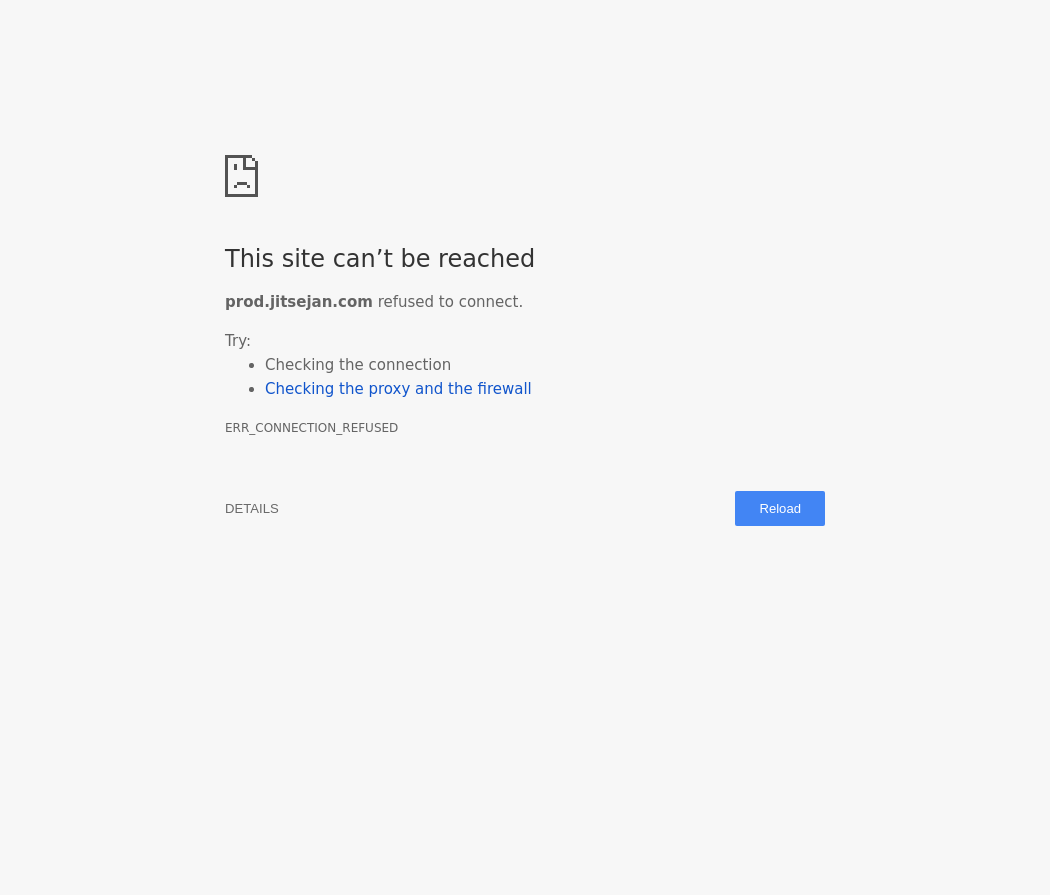

In [76]:
from IPython.display import Image
Image("vue_frontpage.png")

Kill the process on port 8080 after verifying the front page.

In [77]:
process=!fuser 8080/tcp | awk '{print $1}'
vueid = int(process[1])
!kill -9 $vueid

As we can see from the screenshot, we cannot access the page because `webpack` has changed some configuration. In order to circument this we need to add the host to the script in `package.json` and change

```javascript
    "dev": "webpack-dev-server --inline --progress --config build/webpack.dev.conf.js",
```

to

```javascript
    "dev": "webpack-dev-server --inline --progress --config build/webpack.dev.conf.js --host 0.0.0.0",
```

which can be done with `sed`:

In [78]:
!sed -i '/dev.*--inline/s/conf.js/conf.js --host 0.0.0.0/' client/package.json

In [79]:
cat client/package.json | grep dev

    "dev": "webpack-dev-server --inline --progress --config build/webpack.dev.conf.js --host 0.0.0.0",
    "start": "npm run dev",
  "devDependencies": {
    "webpack-dev-server": "^2.9.7",


Additionally we need to disable the host check in `build/webpack.dev.conf.js` by adding 

```javascript
disableHostCheck: true
```

to the `devServer`.

In [80]:
!sed -i "26i\ \ \ \ disableHostCheck: true," client/build/webpack.dev.conf.js

In [81]:
!grep -C3 disableHostCheck client/build/webpack.dev.conf.js --color=auto

  // these devServer options should be customized in /config/index.js
  devServer: {
    clientLogLevel: 'warning',
    disableHostCheck: true,
    historyApiFallback: {
      rewrites: [
        { from: /.*/, to: path.posix.join(config.dev.assetsPublicPath, 'index.html') },


#### Retry

In [82]:
proc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
time.sleep(10)

In [83]:
driver = webdriver.Remote("http://localhost:4444/wd/hub", DesiredCapabilities.CHROME)
driver.get('http://prod.jitsejan.com:8080')
driver.get_screenshot_as_file('vue_front.png')

True

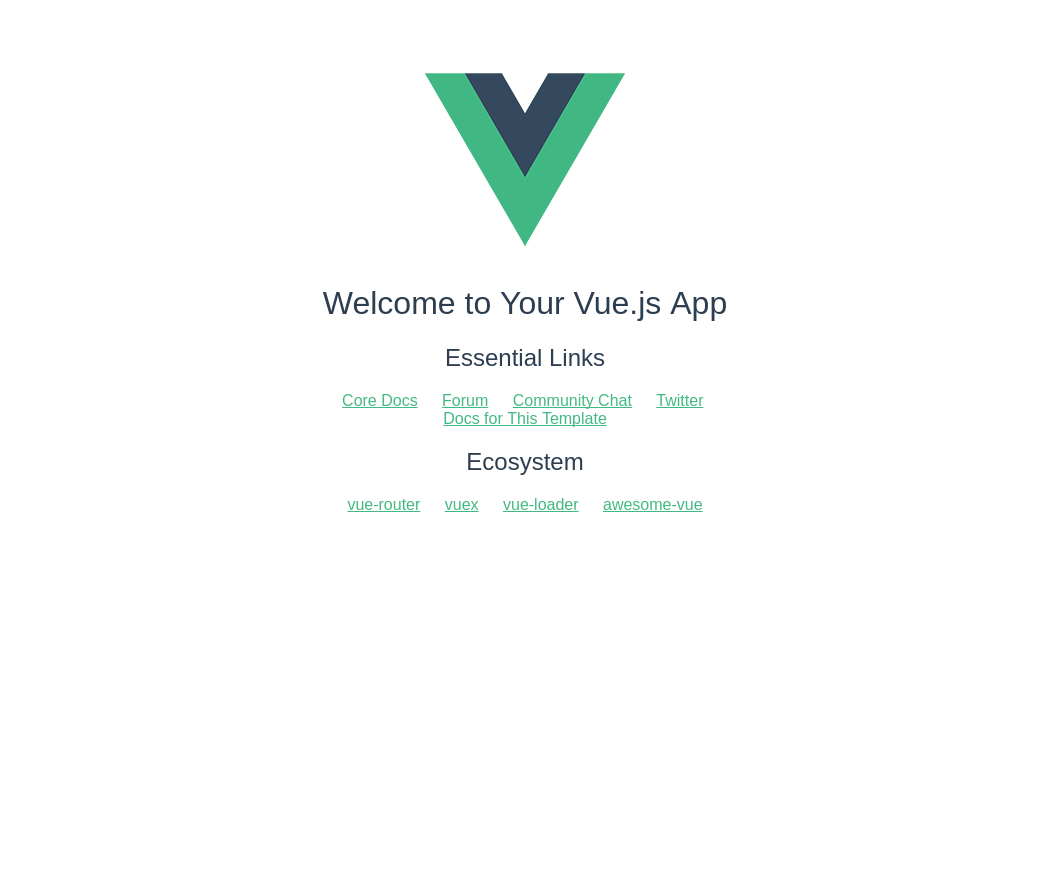

In [84]:
Image("vue_front.png")

In [85]:
process=!fuser 8080/tcp | awk '{print $1}'
vueid = int(process[1])
!kill -9 $vueid

## Create games page

In [86]:
ls client/src/components/

HelloWorld.vue


### Create the component
Add the Vue template to the Games component.

```html
<template>
  <div class="games">
    This page will list all the games.
  </div>
</template>

<script>
export default {
  name: 'Games',
  data () {
    return {}
  }
}
</script>
```

In [87]:
%%file client/src/components/Games.vue
<template>
  <div class="games">
    This page will list all the games.
  </div>
</template>

<script>
export default {
  name: 'Games',
  data () {
    return {}
  }
}
</script>



Writing client/src/components/Games.vue


In [88]:
ls client/src/components/

Games.vue  HelloWorld.vue


### Create the route

In [89]:
cat client/src/router/index.js

import Vue from 'vue'
import Router from 'vue-router'
import HelloWorld from '@/components/HelloWorld'

Vue.use(Router)

export default new Router({
  routes: [
    {
      path: '/',
      name: 'HelloWorld',
      component: HelloWorld
    }
  ]
})


Add the import of the Games component to the router file.

```javascript
import Games from '@/components/Games'
```

and add the path to the games page indicating to which component the page will link.

```javascript
...
    {
      path: '/games',
      name: 'Games',
      component: Games
    }
...
```

In [90]:
%%file client/src/router/index.js
import Vue from 'vue'
import Router from 'vue-router'
import HelloWorld from '@/components/HelloWorld'
import Games from '@/components/Games'

Vue.use(Router)

export default new Router({
  routes: [
    {
      path: '/',
      name: 'HelloWorld',
      component: HelloWorld
    },
    {
      path: '/games',
      name: 'Games',
      component: Games
    }
  ]
})



Overwriting client/src/router/index.js


#### Verify the new route

In [91]:
proc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
time.sleep(10)

driver = webdriver.Remote("http://localhost:4444/wd/hub", DesiredCapabilities.CHROME)
driver.get('http://prod.jitsejan.com:8080/ui/#/games')
driver.get_screenshot_as_file('new_route.png')

process=!fuser 8080/tcp | awk '{print $1}'
vueid = int(process[1])
!kill -9 $vueid

True

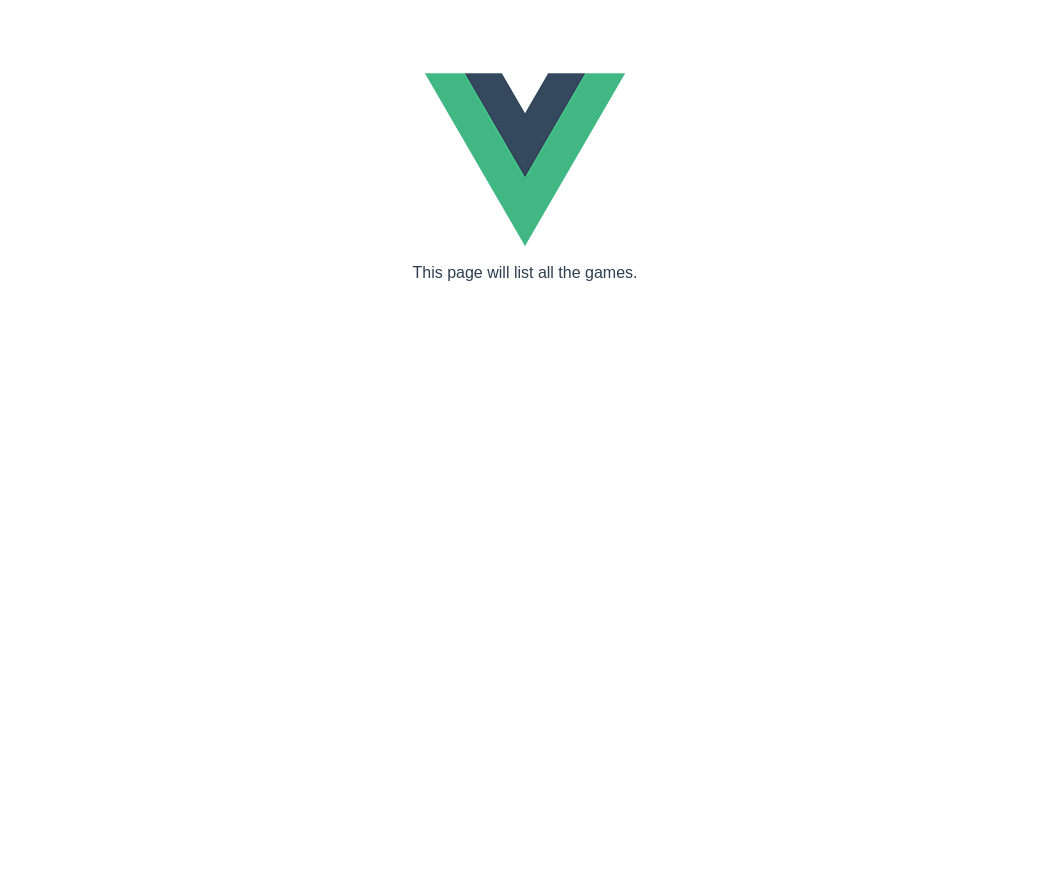

In [92]:
Image("new_route.png")

### Connect to back-end
We have the route complete, time to connect to the data from the database. For this we will use [axios](https://github.com/axios/axios).
#### Install axios

In [93]:
!cd client && npm install --save axios

npm WARN optional SKIPPING OPTIONAL DEPENDENCY: fsevents@1.1.3 (node_modules/fsevents):
npm WARN notsup SKIPPING OPTIONAL DEPENDENCY: Unsupported platform for fsevents@1.1.3: wanted {"os":"darwin","arch":"any"} (current: {"os":"linux","arch":"x64"})

+ axios@0.17.1
added 3 packages in 10.18s


#### Setup connection with back-end
Create a `services` folder that will contain the API Javascript files.

In [94]:
mkdir -p client/src/services

In [95]:
%%file client/src/services/api.js
import axios from 'axios'

export default() => {
  return axios.create({
    baseURL: `http://prod.jitsejan.com:3000`
  })
}



Writing client/src/services/api.js


#### Create service to retrieve the games

In [96]:
%%file client/src/services/GamesService.js
import api from '@/services/api'

export default {
  fetchGames () {
    return api().get('games')
  }
}



Writing client/src/services/GamesService.js


#### Add the service to the Games component
This component shows all the games available in the database. Note that this is the file that should be updated if you would like a more fancy layout, for example by adding [Bootstrap](https://getbootstrap.com/) or other frameworks.

```html
<template>
  <div class="games">
    <div class="games-div" v-for="game in games" :key="game._id">
      <p>
        <span><b>{{ game.name }}</b></span><br />
        <span>{{ game.console }}</span><br />
        <span>{{ game.sales }}</span>
        <a :href="'/ui/#/games/' + game._id">Details</a>
      </p>
    </div>
  </div>
</template>

<script>
import GamesService from '@/services/GamesService'

export default {
  name: 'Games',
  data () {
    return {
      games: []
    }
  },
  mounted () {
    this.getGames()
  },
  methods: {
    async getGames () {
      const response = await GamesService.fetchGames()
      this.games = response.data.games
    }
  }
}
</script>
```

In [97]:
%%file client/src/components/Games.vue
<template>
  <div class="games">
    <div class="games-div" v-for="game in games" :key="game._id">
      <p>
        <span><b>{{ game.name }}</b></span><br />
        <span>{{ game.console }}</span><br />
        <span>{{ game.sales }}</span>
        <a :href="'/ui/#/games/' + game._id">Details</a>
      </p>
    </div>
  </div>
</template>

<script>
import GamesService from '@/services/GamesService'

export default {
  name: 'Games',
  data () {
    return {
      games: []
    }
  },
  mounted () {
    this.getGames()
  },
  methods: {
    async getGames () {
      const response = await GamesService.fetchGames()
      this.games = response.data.games
    }
  }
}
</script>



Overwriting client/src/components/Games.vue


Start both the Express back-end and the Vue front-end to verify if the data from the API is retrieved with the updated component.

Small trick: by setting the logging preferences when starting the webdriver with Selenium, we can actually retrieve the logs you would normally see with the developer tools in the browser.

In [98]:
vueproc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
expressproc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)

time.sleep(10)

desired = DesiredCapabilities.CHROME
desired ['loggingPrefs'] = { 'browser':'ALL' }
        
driver = webdriver.Remote("http://localhost:4444/wd/hub", desired_capabilities=desired)
driver.get('http://prod.jitsejan.com:8080/ui/#/games')
driver.get_screenshot_as_file('new_route_with_data.png')

vueprocess=!fuser 8080/tcp | awk '{print $1}'
vueid = int(vueprocess[1])
!kill -9 $vueid

expressprocess=!fuser 3000/tcp | awk '{print $1}'
expressid = int(expressprocess[1])
!kill -9 $expressid

True

In [99]:
logs = driver.get_log('browser')
logs

[{'level': 'INFO',
  'message': 'webpack-internal:///./node_modules/webpack/hot/log.js 22:11 "[HMR] Waiting for update signal from WDS..."',
  'source': 'console-api',
  'timestamp': 1516064762951},
 {'level': 'INFO',
  'message': 'webpack-internal:///./node_modules/vue/dist/vue.esm.js 8437:44 "Download the Vue Devtools extension for a better development experience:\\nhttps://github.com/vuejs/vue-devtools"',
  'source': 'console-api',
  'timestamp': 1516064763382},
 {'level': 'SEVERE',
  'message': "http://prod.jitsejan.com:8080/ui/#/games - Failed to load http://prod.jitsejan.com:3000/games: No 'Access-Control-Allow-Origin' header is present on the requested resource. Origin 'http://prod.jitsejan.com:8080' is therefore not allowed access.",
  'source': 'javascript',
  'timestamp': 1516064763546},
 {'level': 'SEVERE',
  'message': 'webpack-internal:///./node_modules/axios/lib/core/createError.js 15:14 Uncaught Error: Network Error',
  'source': 'javascript',
  'timestamp': 151606476354

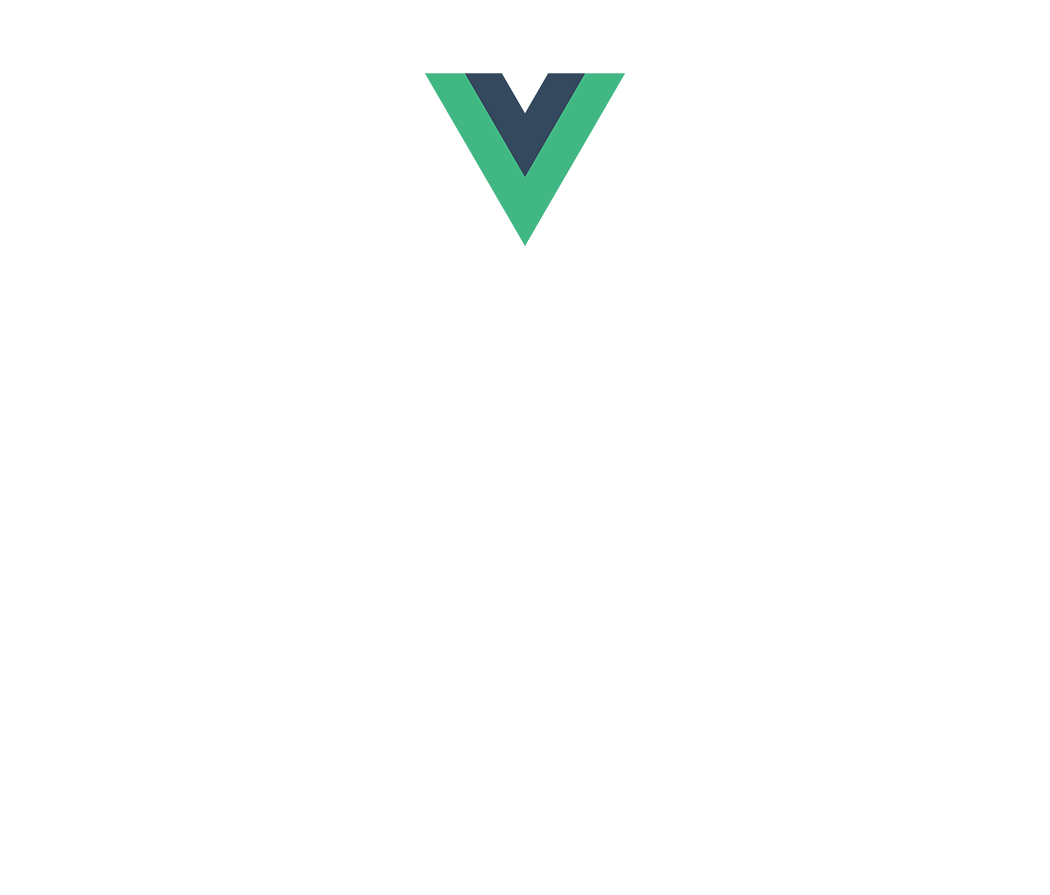

In [100]:
Image("new_route_with_data.png")

As we can see in the logs, we have an issue accessing the back-end because of the Access-Control-Allow-Origin limitation. To circumvent this, we need to make sure that we are allowed to access the API; hece install the package [Cors](https://www.npmjs.com/package/cors) and enable it in the Express application.

In [101]:
!cd server && npm install --save cors

+ cors@2.8.4m......] / postinstall: info lifecycle cors@2.8.4~postinstall: cors
added 2 packages in 1.115s


Add the requirement for the cors package and enable it in the Express app by adding the following to `server/app.js`.

```javascript
...
var cors = require('cors')
...
app.use(cors())
...
```

In [102]:
%%file server/app.js
var express = require('express');
var path = require('path');
var favicon = require('serve-favicon');
var logger = require('morgan');
var cookieParser = require('cookie-parser');
var bodyParser = require('body-parser');
// Mongoose connection
var mongoose = require('mongoose');
mongoose.connect('mongodb://localhost:27017/nintendo');
var db = mongoose.connection;
db.on("error", console.error.bind(console, "Connection error"));
db.once("openUri", function(callback){
  console.log("Connection successful")
});
var cors = require("cors")

var index = require('./routes/index');
var users = require('./routes/users');
var games = require('./routes/games');

var app = express();
app.use(cors());

// view engine setup
app.set('views', path.join(__dirname, 'views'));
app.set('view engine', 'ejs');

// uncomment after placing your favicon in /public
//app.use(favicon(path.join(__dirname, 'public', 'favicon.ico')));
app.use(logger('dev'));
app.use(bodyParser.json());
app.use(bodyParser.urlencoded({ extended: false }));
app.use(cookieParser());
app.use(express.static(path.join(__dirname, 'public')));

app.use('/', index);
app.use('/users', users);
app.use('/games', games);

// catch 404 and forward to error handler
app.use(function(req, res, next) {
  var err = new Error('Not Found');
  err.status = 404;
  next(err);
});

// error handler
app.use(function(err, req, res, next) {
  // set locals, only providing error in development
  res.locals.message = err.message;
  res.locals.error = req.app.get('env') === 'development' ? err : {};

  // render the error page
  res.status(err.status || 500);
  res.render('error');
});

module.exports = app;

Overwriting server/app.js


Now we are connected and allowed to retrieve the data. We use Selenium and wait for the `games-div` to appear.

In [103]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

vueproc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
expressproc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)

time.sleep(10)

desired = DesiredCapabilities.CHROME
desired ['loggingPrefs'] = { 'browser':'ALL' }
        
driver = webdriver.Remote("http://localhost:4444/wd/hub", desired_capabilities=desired)
driver.get('http://prod.jitsejan.com:8080/ui/#/games')
WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CLASS_NAME, 'games-div')))
driver.refresh()
driver.save_screenshot('allgames.png')

<selenium.webdriver.remote.webelement.WebElement (session="ba1712b1e5ede5037de7ff15d2b109fc", element="0.8736937714035513-1")>

True

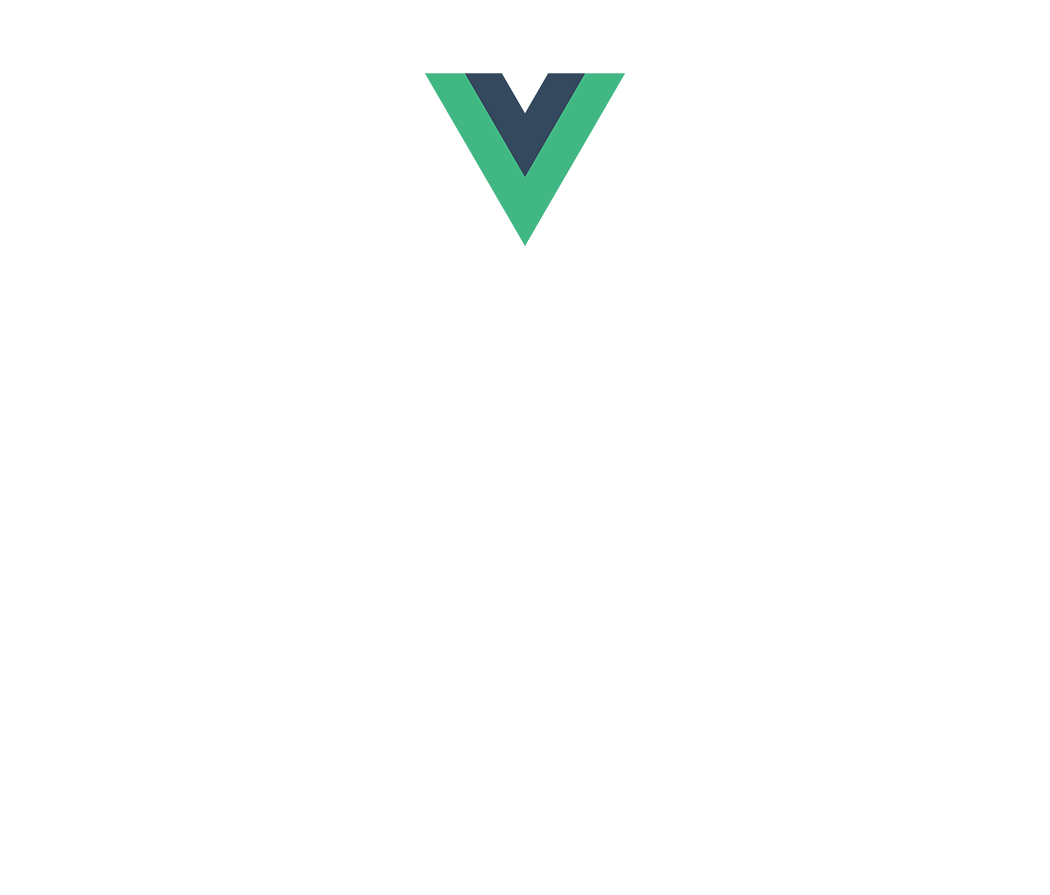

In [104]:
Image("allgames.png")

#### Clean up

In [105]:
driver.quit()

vueprocess=!fuser 8080/tcp | awk '{print $1}'
vueid = int(vueprocess[1])
!kill -9 $vueid

expressprocess=!fuser 3000/tcp | awk '{print $1}'
expressid = int(expressprocess[1])
!kill -9 $expressid

#### Create detail page for the game
Create the component and connect to the API by importing the service and execute the promise. Retrieving the data for a game can also be solved by extending the `GamesServices.js` we created earlier by adding another fetch function, but since every problem can be solved in different ways, I chose to use the method as shown in the following file.

```html
<template>
  <div class="games-detail">
    <h1>Details for {{ data.name }}</h1>
    <img :src="'/static/' + data.image" /><br/>
    Console: {{ data.console }}<br/>
    Sales: {{ data.sales}} million<br/>
  </div>
</template>

<script>
import api from '@/services/api'

export default {
  name: 'GamesDetail',
  data () {
    return {
      data: ''
    }
  },
  created () {
    api().get('games/' + this.$route.params.id)
      .then(response => {
        this.data = response.data
      })
      .catch(e => {
        this.errors.push(e)
      })
  }
}
</script>
```

In [106]:
%%file client/src/components/GamesDetail.vue
<template>
  <div class="games-detail">
    <h1>Details for {{ data.name }}</h1>
    <img :src="'/static/' + data.image" /><br/>
    Console: {{ data.console }}<br/>
    Sales: {{ data.sales}} million<br/>
  </div>
</template>

<script>
import api from '@/services/api'

export default {
  name: 'GamesDetail',
  data () {
    return {
      data: ''
    }
  },
  created () {
    api().get('games/' + this.$route.params.id)
      .then(response => {
        this.data = response.data
      })
      .catch(e => {
        this.errors.push(e)
      })
  }
}
</script>



Writing client/src/components/GamesDetail.vue


Add the route for the detail page by adding the following to `client/src/router/index.js`:
    
```javascript
...
import GamesDetail from '@/components/GamesDetail'
...
    {
      path: '/games/:id',
      name: 'GamesDetail',
      component: GamesDetail
    }
```

In [107]:
%%file client/src/router/index.js
import Vue from 'vue'
import Router from 'vue-router'
import HelloWorld from '@/components/HelloWorld'
import Games from '@/components/Games'
import GamesDetail from '@/components/GamesDetail'

Vue.use(Router)

export default new Router({
  routes: [
    {
      path: '/',
      name: 'HelloWorld',
      component: HelloWorld
    },
    {
      path: '/games',
      name: 'Games',
      component: Games
    },
    {
      path: '/games/:id',
      name: 'GamesDetail',
      component: GamesDetail
    }
  ]
})



Overwriting client/src/router/index.js


Start the processes

In [108]:
vueproc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
expressproc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)
time.sleep(10)

Verify the detail page for a given ID.

In [109]:
desired = DesiredCapabilities.CHROME
desired ['loggingPrefs'] = { 'browser':'ALL' }
        
driver = webdriver.Remote("http://localhost:4444/wd/hub", desired_capabilities=desired)
driver.get('http://prod.jitsejan.com:8080/ui/#/games/'+game_id)
driver.save_screenshot('gamedetail.png')

True

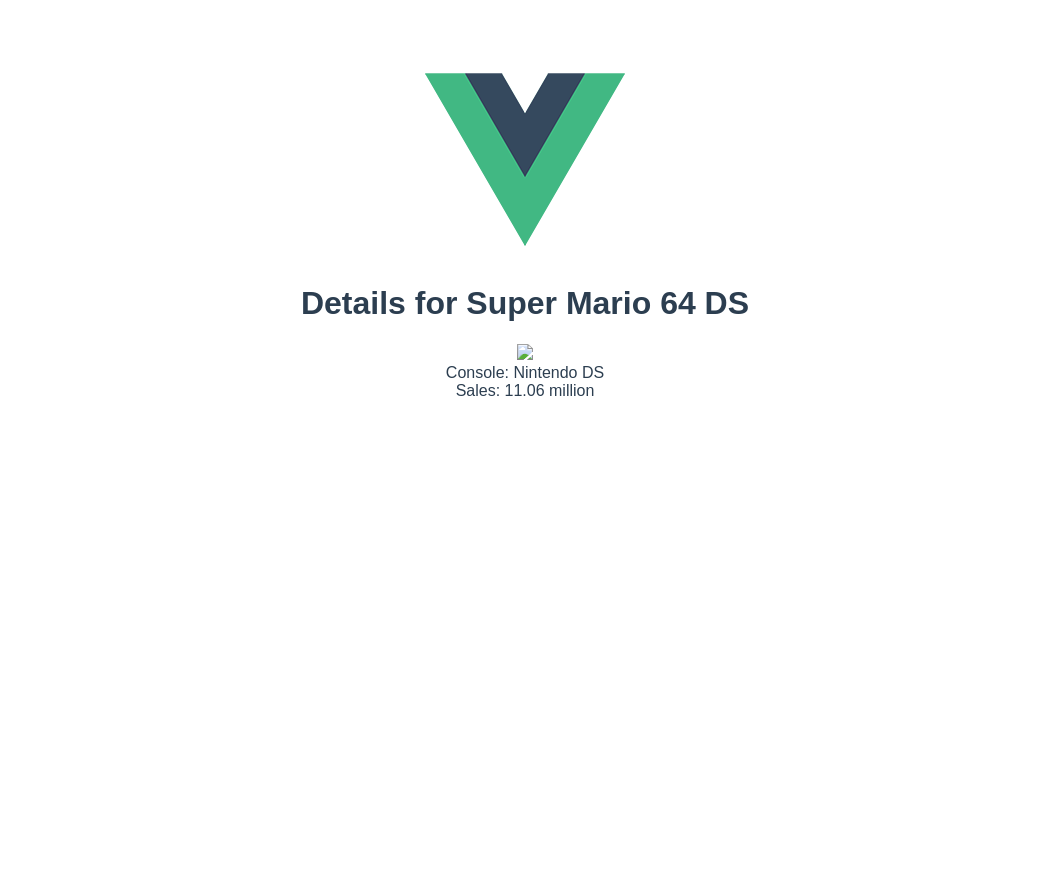

In [110]:
Image("gamedetail.png")

Note: not all images from the source are working properly, but that could easily be fixed by improving the webscraper and verifying the images.

In [111]:
vueprocess=!fuser 8080/tcp | awk '{print $1}'
vueid = int(vueprocess[1])
!kill -9 $vueid

expressprocess=!fuser 3000/tcp | awk '{print $1}'
expressid = int(expressprocess[1])
!kill -9 $expressid

### Finalize
To wrap this notebook up, lets update the generic `App.vue` to make it easier to navigate between the pages by adding a menu to `client/src/App.vue`. Copy the following text to the `client/src/App.vue`.

```html
<template>
  <div id="app">
    <router-link :to="{ name: 'HelloWorld' }">Home</router-link>
    <router-link :to="{ name: 'Games'}">Games</router-link>
    <router-view/>
  </div>
</template>

<script>
export default {
  name: 'app'
}
</script>

<style>
#app {
  font-family: 'Avenir', Helvetica, Arial, sans-serif;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  text-align: center;
  color: #2c3e50;
  margin-top: 60px;
}
</style>
```

In [112]:
%%file client/src/App.vue
<template>
  <div id="app">
    <router-link :to="{ name: 'HelloWorld' }">Home</router-link>
    <router-link :to="{ name: 'Games'}">Games</router-link>
    <router-view/>
  </div>
</template>

<script>
export default {
  name: 'app'
}
</script>

<style>
#app {
  font-family: 'Avenir', Helvetica, Arial, sans-serif;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  text-align: center;
  color: #2c3e50;
  margin-top: 60px;
}
</style>



Overwriting client/src/App.vue


In [113]:
vueproc = subprocess.Popen("cd client && npm run dev &", shell=True, stdout=subprocess.PIPE)
expressproc = subprocess.Popen("cd server && npm start &", shell=True, stdout=subprocess.PIPE)
time.sleep(10)

In [114]:
desired = DesiredCapabilities.CHROME
desired ['loggingPrefs'] = { 'browser':'ALL' }
        
driver = webdriver.Remote("http://localhost:4444/wd/hub", desired_capabilities=desired)
driver.get('http://prod.jitsejan.com:8080')
driver.save_screenshot('menuadded.png')

True

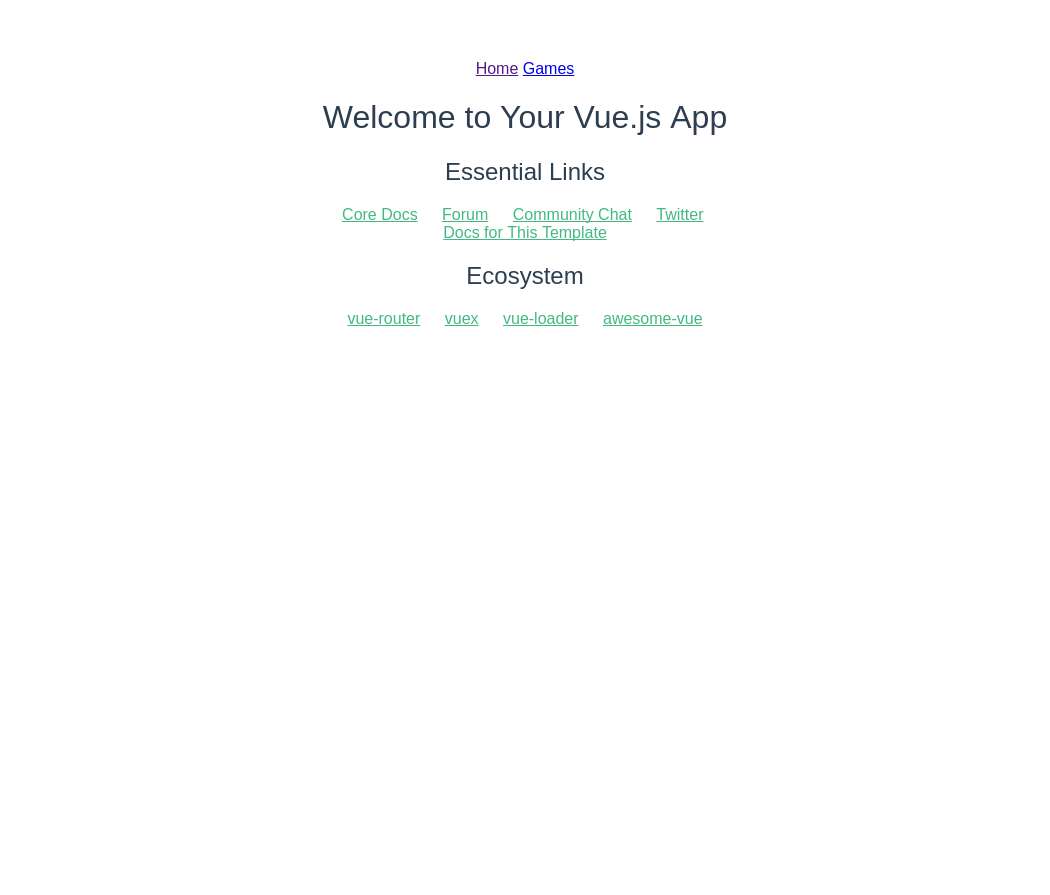

In [115]:
Image("menuadded.png")

#### Clean up

In [116]:
%%bash
rm -rf client
rm -rf server
rm -rf iamges

## Future work
In this example application I did not use any fancy styling or advanced HTML structures to make the website more appealing. Additionally, the API is only used to retrieve data, while obviously it could also used to create data, update it or delete it (CRUD), but for the scope of this notebook I kept it to a minimum. As a third improvement you could choose to put everything of this notebook in one Docker compose file, where MongoDB, Selenium, ExpressJS and VueJS are all containerized, but since I am not planning to port this application to another server, it is fine to simply install the files locally and remove them again after the notebook has finished.